# First steps in  *pandas*

***
> __Auteur__: Joseph Salmon
> <joseph.salmon@umontpellier.fr> , adapted from the notebook by Joris Van den Bossche:
https://github.com/jorisvandenbossche/pandas-tutorial/blob/master/01-pandas_introduction.ipynb

<a id="intro"> </a>

# Introduction et présentation

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact  # widget manipulation

pd.options.display.max_rows = 8
from download import download

## Cas 1: Survie sur le Titanic 

In [2]:
url = "http://josephsalmon.eu/enseignement/datasets/titanic.csv"
path_target = "./titanic.csv"
download(url, path_target, replace=False)

# df: data frame
df_titanic_raw = pd.read_csv("titanic.csv")

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.


In [3]:
df_titanic_raw.tail(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Valeurs manquantes:
Pour faciliter la suite on ne garde que les observations qui sont complètes, on enlève donc ici les valeurs manquantes

In [4]:
df_titanic = df_titanic_raw.dropna()
df_titanic.tail(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Description succinte des variables:
- Survival - Survie (0 = Non; 1 = Oui).
- Pclass - Passenger Class / Classe du passager (1 = 1ere; 2 = 2nde; 3 = 3ème)
- Name - Nom
- Sex - Sexe
- Age - Age
- Sibsp - Nombre de frères / soeurs / maris / épouses à bord
- Parch - Nombre de parents ascendants / enfants à bord
- Ticket - Numéro du ticket
- Fare - Prix du ticket (British pound)
- Cabin - Cabine
- Embarked - Port d'embarquation (C = Cherbourg; Q = Queenstown; S = Southampton)

# Descriptif rapide:
- count - effectif
- mean - moyenne
- std (**st**andard **d**eviation - écart-type)


In [5]:
df_titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,455.366120,0.672131,1.191257,35.674426,0.464481,0.475410,78.682469
std,247.052476,0.470725,0.515187,15.643866,0.644159,0.754617,76.347843
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.500000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,676.000000,1.000000,1.000000,47.500000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


## Compréhension visualisation de la base de données:

**Quelle est la répartition par âge des passagers?**

<IPython.core.display.Javascript object>


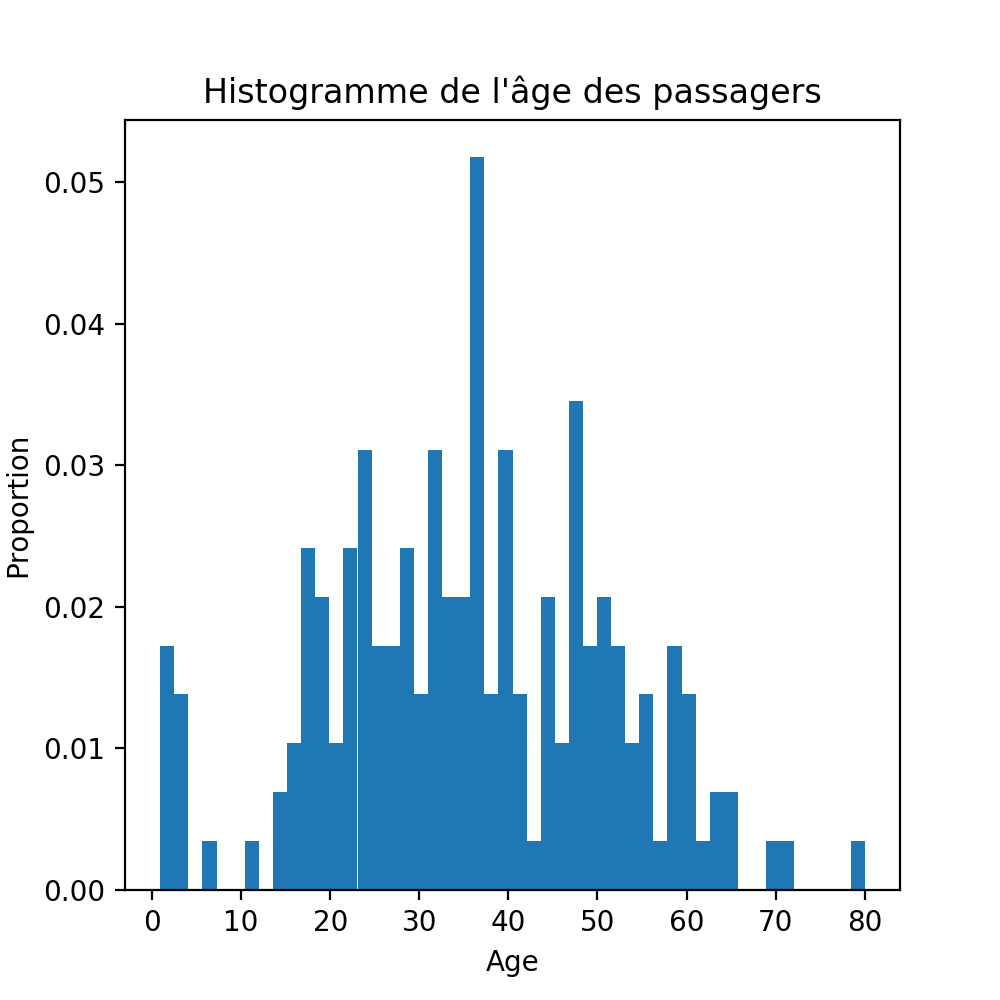

Text(0.5, 1.0, "Histogramme de l'âge des passagers")

In [6]:
plt.figure(figsize=(5, 5))
plt.hist(df_titanic['Age'], density=True, bins=50)
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.title("Histogramme de l'âge des passagers")

<IPython.core.display.Javascript object>


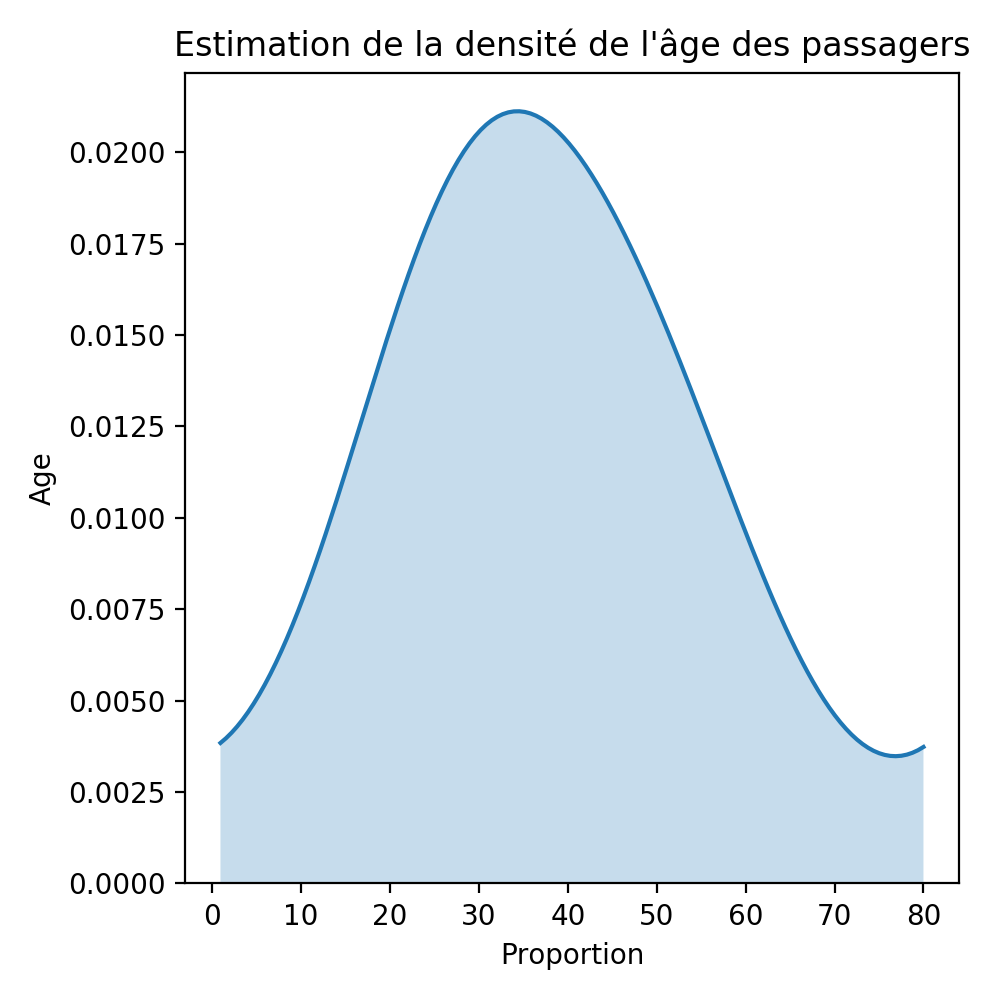

In [7]:
plt.figure(figsize=(5, 5), num='jfpwje')
# KDE: kernel density estimate
ax = sns.kdeplot(df_titanic['Age'], shade=True, cut=0, bw=10) # sns -> Seaborn package
plt.xlabel('Proportion')
plt.ylabel('Age')
ax.legend().set_visible(False)
plt.title("Estimation de la densité de l'âge des passagers")
plt.tight_layout()

### <font color='red'> EXERCISE : density over histrogram </font>
Plot the density estimate over the histogram

<IPython.core.display.Javascript object>


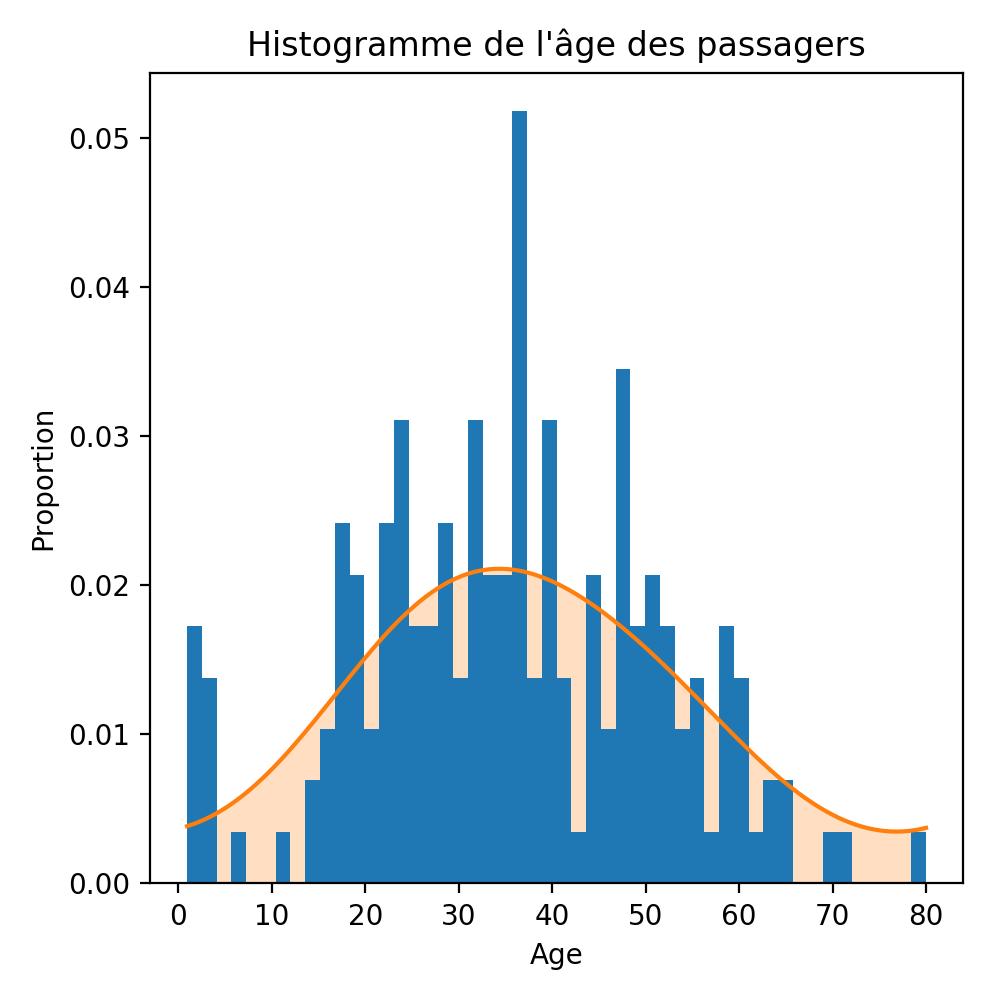

In [8]:
plt.figure(figsize=(5, 5))
plt.hist(df_titanic['Age'], density=True, bins=50)
plt.xlabel('Age')
plt.ylabel('Proportion')
plt.title("Histogramme de l'âge des passagers")
ax = sns.kdeplot(df_titanic['Age'], shade=True, cut=0, bw=10) # sns -> Seaborn package
ax.legend().set_visible(False)
plt.tight_layout()

## Widget
Interactive interaction with codes and output is nowdays easier and easier (see also Shiny app in R-software).
In `jupyter notebook` one can use for that `widgets` and the `interact` package. We are going to visualise that on the simple KDE and histograms examples.

In [9]:
def hist_explore(n_bins=24, alpha=0.25, density=False):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.hist(df_titanic['Age'], density=density,
            bins=n_bins, alpha=0.25)  # standardization
    plt.xlabel('Age')
    plt.ylabel('Density level')
    plt.title("Histogram for passengers' age")
    plt.tight_layout()
    plt.show()

In [10]:
interact(hist_explore, n_bins=(1, 50, 1), alpha=(0, 1, 0.1), density=False)

interactive(children=(IntSlider(value=24, description='n_bins', max=50, min=1), FloatSlider(value=0.25, descri…

<function __main__.hist_explore(n_bins=24, alpha=0.25, density=False)>

In [11]:
def kde_explore(bw=5):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax = sns.kdeplot(df_titanic['Age'], bw=bw, shade=True, cut=0)
    plt.xlabel('Age (in year)')
    plt.ylabel('Density level')
    plt.title("Age of the passengers")
    plt.tight_layout()
    plt.show()

In [12]:
interact(kde_explore, bw=(0.001, 10, 0.1))

interactive(children=(FloatSlider(value=5.0, description='bw', max=10.0, min=0.001), Output()), _dom_classes=(…

<function __main__.kde_explore(bw=5)>

## `Groupby` function
How is the survival rate change w.r.t. to sex?

In [13]:
df_titanic_raw.groupby('Sex')[['Survived']].aggregate(lambda x: x.mean())

,Survived
Sex,
female,0.742038
male,0.188908


How is the survival rate change w.r.t. the class?

In [14]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<IPython.core.display.Javascript object>


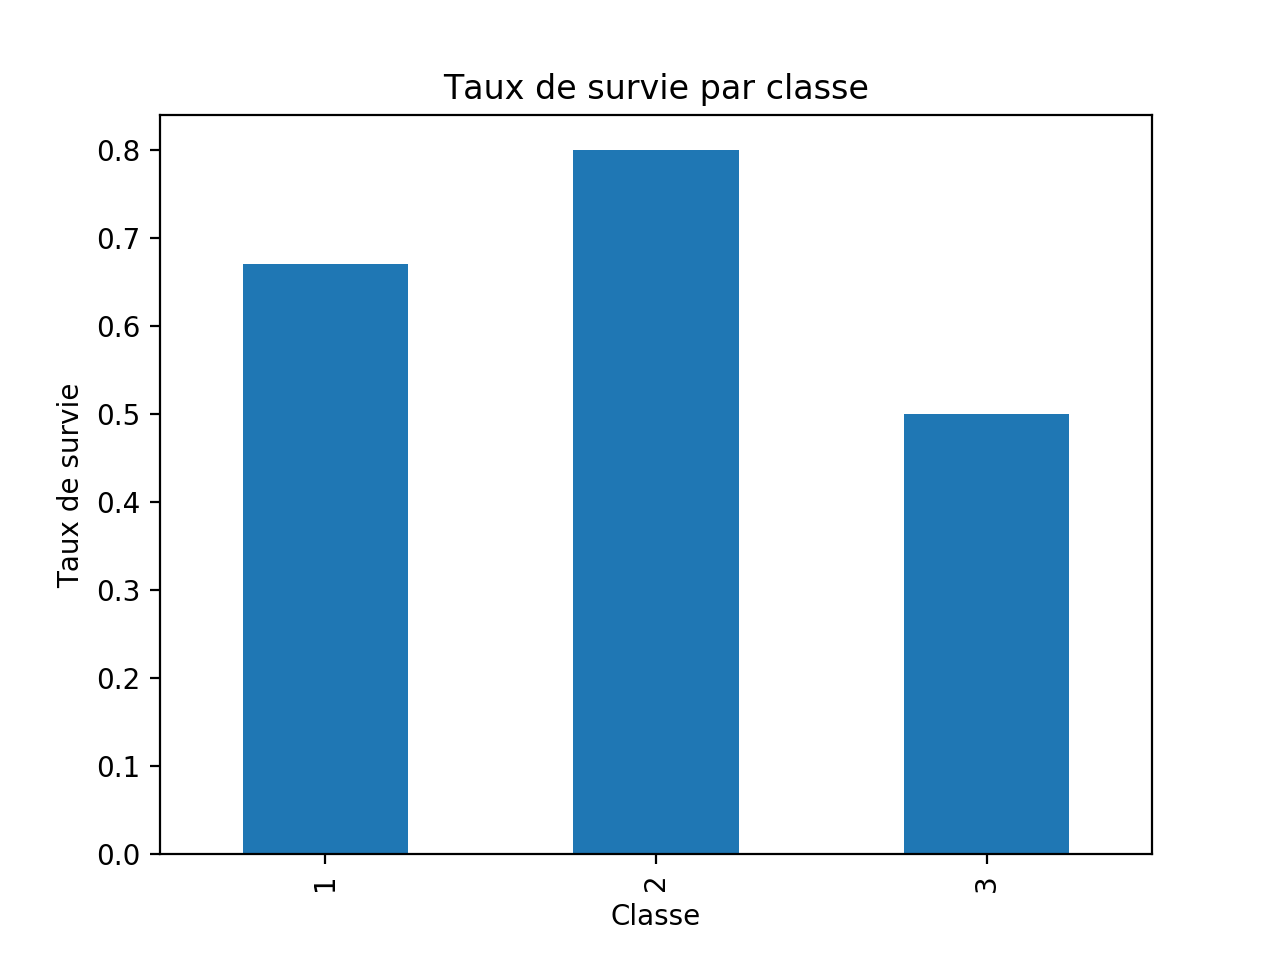

In [15]:
plt.figure()
df_titanic.groupby('Pclass')['Survived'].aggregate(lambda x: x.mean()).plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Taux de survie')
plt.title('Taux de survie par classe')
plt.show()

### <font color='red'> EXERCISE : Improve graphics </font>
Add correct ylabel to the previous figure.

<IPython.core.display.Javascript object>


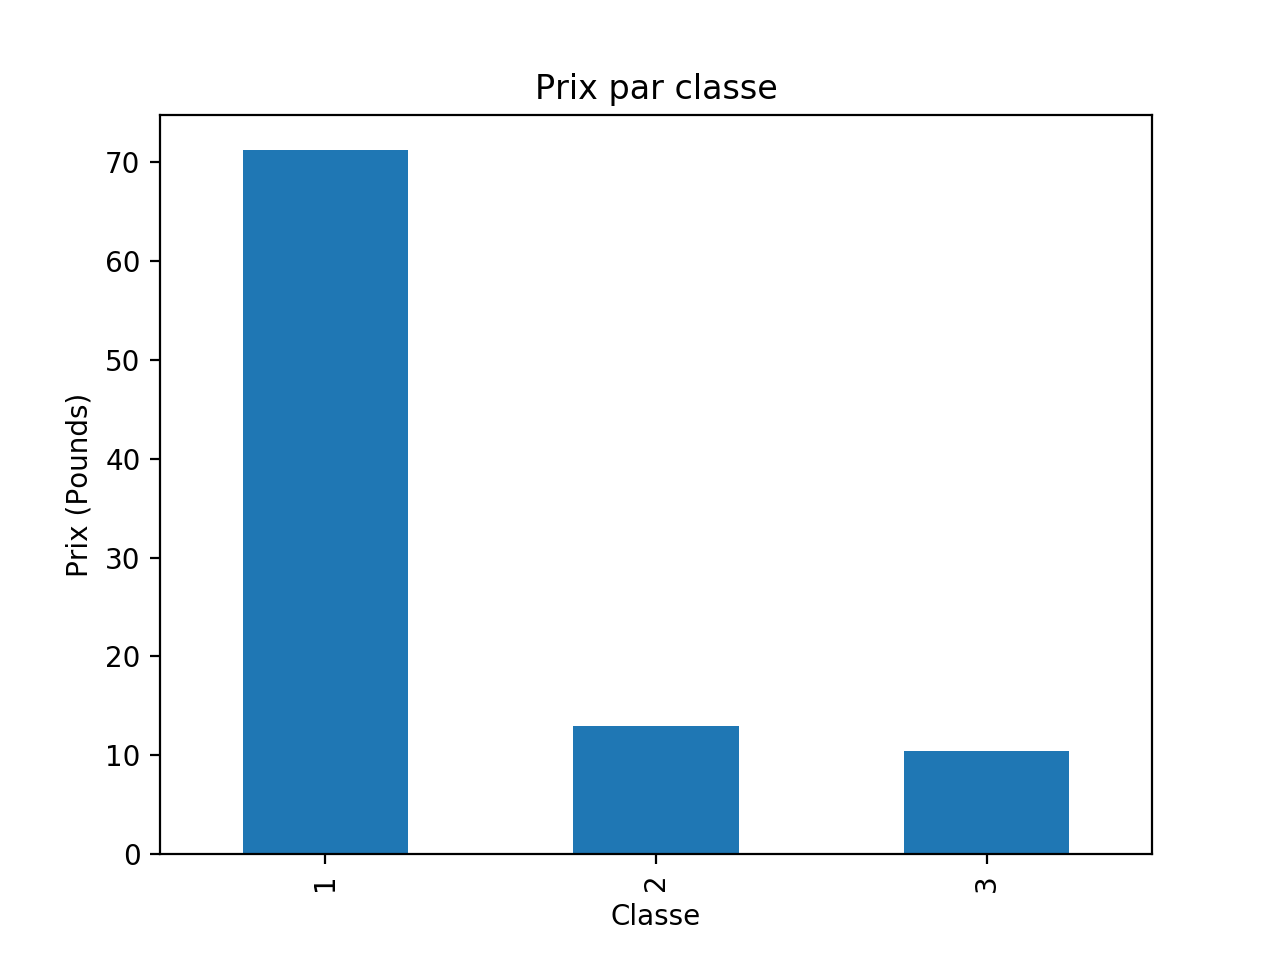

In [16]:
plt.figure()
df_titanic.groupby('Pclass')['Fare'].aggregate(lambda x: x.median()).plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Prix (Pounds)')
plt.title('Prix par classe')
plt.show()

### <font color='red'> EXERCISE : median by class </font>
Perform a similar analysis with the median for the price per class in pounds.

## Catplot, or a visual groupby

<IPython.core.display.Javascript object>


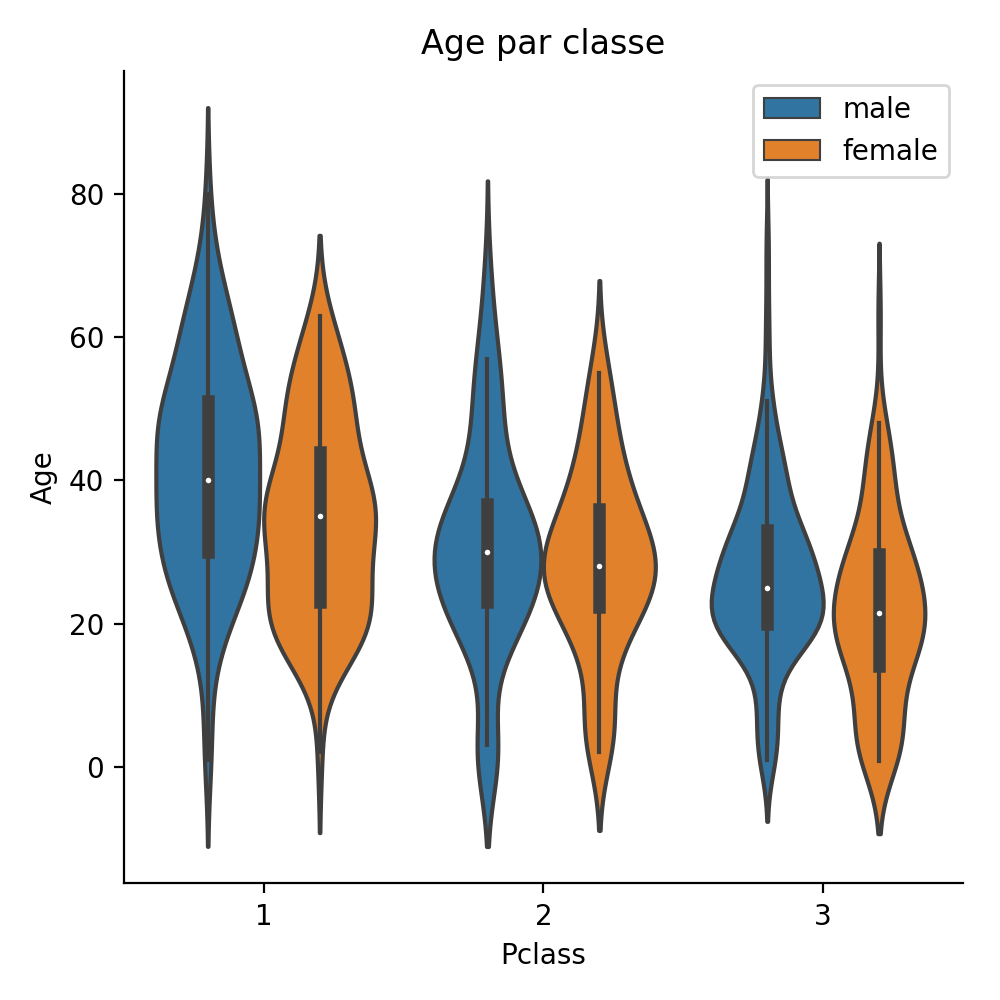

In [17]:
sns.catplot(x=df_titanic_raw.columns[2], y="Age",
            hue="Sex", data=df_titanic_raw, kind="violin", legend=False)
plt.title("Age par classe")
plt.legend(loc=1)
plt.tight_layout()

# Pandas: anlayser des données avec Python 

Pour les travaux intensifs en données en Python, la bibliothèque Pandas est devenue essentielle.

Qu'est ce que pandas? C'est un environnement qui gère des Data Frame:

- Pandas peut gérer *Data Frame* des tableaux *numpy* avec des étiquettes pour les lignes et les colonnes, et permet une prise en charge des types de données hétérogènes.
- Pandas peut aussi être considéré comme le data.frame de R en Python.
- Puissant pour travailler avec les données manquantes, travailler avec des données chronologiques, pour lire et écrire vos données, pour remodeler, regrouper, fusionner vos données, ...

Documentation: http://pandas.pydata.org/pandas-docs/stable/

Quand a-t-on besoin de Pandas?
Quand on travaille avec des tableaux ou des structures de données(commme des dataframe R, SQL table, Excel, Spreadsheet, ...):

- Importer des données
- Nettoyer des données "sales" 
- Explorer et comprendre des données
- Traiter et preparer les données pour faire une analyse 
- Analyser les données (avec en plus scikit-learn, statsmodels,...)
<br/>
<br/>

**ATTENTION / LIMITES:**

Pandas est bon pour travailler avec des données hétérogènes et des tableaux 1D/2D, mais tous les types de données ne correspondent pas à ces structures!

Contre-exemples:
- Quand on travaille avec des données de type **array** (e.g. images):  utiliser *numpy*
- Pour des données multidimensionnelles étiquetées  (e.g. données de climat): voir [xarray](http://xarray.pydata.org/en/stable/)

# Les structures de données en pandas : DataFrame et Series

Un DataFrame est une structure de données tabulaire (un objet multidimensionnel pouvant contenir des données étiquetées) composé de lignes et de colonnes, semblable à une feuille de calcul, une table de base de données ou à l'objet data.frame de R. Vous pouvez le considérer comme plusieurs objets Series partageant le même index.

In [18]:
df_titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
...,...,...,...,...,...,...,...,...,...,...,...,...
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [19]:
df_titanic.index

Int64Index([  1,   3,   6,  10,  11,  21,  23,  27,  52,  54,
            ...
            835, 853, 857, 862, 867, 871, 872, 879, 887, 889],
           dtype='int64', length=183)

In [20]:
df_titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [21]:
pd.options.display.max_rows = 12
df_titanic.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [22]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 889
Data columns (total 12 columns):
PassengerId    183 non-null int64
Survived       183 non-null int64
Pclass         183 non-null int64
Name           183 non-null object
Sex            183 non-null object
Age            183 non-null float64
SibSp          183 non-null int64
Parch          183 non-null int64
Ticket         183 non-null object
Fare           183 non-null float64
Cabin          183 non-null object
Embarked       183 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 18.6+ KB


In [23]:
# Check that cabin is mostly missing, also the age
df_titanic_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [24]:
array_titanic = df_titanic.values  # c'est la liste de valeur /array associé
array_titanic

array([[2, 1, 1, ..., 71.2833, 'C85', 'C'],
       [4, 1, 1, ..., 53.1, 'C123', 'S'],
       [7, 0, 1, ..., 51.8625, 'E46', 'S'],
       ...,
       [880, 1, 1, ..., 83.1583, 'C50', 'C'],
       [888, 1, 1, ..., 30.0, 'B42', 'S'],
       [890, 1, 1, ..., 30.0, 'C148', 'C']], dtype=object)

### <font color='red'> EXERCISE : dropna</font>
Perform the following operation: remove the columns Cabin, and then remove the rows with missing age.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html


In [25]:
del df_titanic_raw['Cabin']

In [26]:
df_titanic_raw = df_titanic_raw.dropna(subset=['Age'])
df_titanic_raw.info()
# ou
# df_titanic_raw.drop(labels=['Cabin'], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    714 non-null int64
Survived       714 non-null int64
Pclass         714 non-null int64
Name           714 non-null object
Sex            714 non-null object
Age            714 non-null float64
SibSp          714 non-null int64
Parch          714 non-null int64
Ticket         714 non-null object
Fare           714 non-null float64
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 66.9+ KB


# Données uni-dimensionel : Series (une colonne d'un DataFrame)

Une Series est un support de base pour les données étiquetées unidimensionnelles.

In [27]:
fare = df_titanic['Fare']

In [28]:
fare

1      71.2833
3      53.1000
6      51.8625
10     16.7000
11     26.5500
21     13.0000
        ...   
867    50.4958
871    52.5542
872     5.0000
879    83.1583
887    30.0000
889    30.0000
Name: Fare, Length: 183, dtype: float64

## Attributs de l'objet *Series*: indices et valeurs

In [29]:
fare.values[:10]

array([ 71.2833,  53.1   ,  51.8625,  16.7   ,  26.55  ,  13.    ,
        35.5   , 263.    ,  76.7292,  61.9792])

In [30]:
fare[6] # existe mais fare[0] provoque une erreur, car on l'a enlevé du dataFrame, comme valeur manquante.


51.8625

Contrairement au tableau *numpy*, cet index peut être autre chose qu'un entier:

In [31]:
df_titanic = df_titanic.set_index('Name')
df_titanic

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Name,,,,,,,,,,,
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",4,1,1,female,35.0,1,0,113803,53.1000,C123,S
"McCarthy, Mr. Timothy J",7,0,1,male,54.0,0,0,17463,51.8625,E46,S
"Sandstrom, Miss. Marguerite Rut",11,1,3,female,4.0,1,1,PP 9549,16.7000,G6,S
"Bonnell, Miss. Elizabeth",12,1,1,female,58.0,0,0,113783,26.5500,C103,S
"Beesley, Mr. Lawrence",22,1,2,male,34.0,0,0,248698,13.0000,D56,S
...,...,...,...,...,...,...,...,...,...,...,...
"Roebling, Mr. Washington Augustus II",868,0,1,male,31.0,0,0,PC 17590,50.4958,A24,S
"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",872,1,1,female,47.0,1,1,11751,52.5542,D35,S


In [32]:
age = df_titanic['Age']
age['Behr, Mr. Karl Howell']

26.0

In [33]:
age.mean()

35.6744262295082

In [34]:
df_titanic[age <2]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Name,,,,,,,,,,,
"Becker, Master. Richard F",184,1,2,male,1.00,2,1,230136,39.00,F4,S
"Allison, Master. Hudson Trevor",306,1,1,male,0.92,1,2,113781,151.55,C22 C26,S


In [35]:
df_titanic_raw['Embarked'].value_counts()

S    554
C    130
Q     28
Name: Embarked, dtype: int64

In [36]:
pd.options.display.max_rows = 70
df_titanic[df_titanic['Embarked']=='C']  # Les passagers montés à Cherbourg n'ont pas des noms gaulois...

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Name,,,,,,,,,,,
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
"Harper, Mrs. Henry Sleeper (Myna Haxtun)",53,1,1,female,49.0,1,0,PC 17572,76.7292,D33,C
"Ostby, Mr. Engelhart Cornelius",55,0,1,male,65.0,0,1,113509,61.9792,B30,C
"Goldschmidt, Mr. George B",97,0,1,male,71.0,0,0,PC 17754,34.6542,A5,C
"Greenfield, Mr. William Bertram",98,1,1,male,23.0,0,1,PC 17759,63.3583,D10 D12,C
"Baxter, Mr. Quigg Edmond",119,0,1,male,24.0,0,1,PC 17558,247.5208,B58 B60,C
"Giglio, Mr. Victor",140,0,1,male,24.0,0,0,PC 17593,79.2000,B86,C
"Smith, Mr. James Clinch",175,0,1,male,56.0,0,0,17764,30.6958,A7,C
"Isham, Miss. Ann Elizabeth",178,0,1,female,50.0,0,0,PC 17595,28.7125,C49,C


In [37]:
pd.options.display.max_rows = 8

In [38]:
df_titanic_raw['Survived'].sum() / df_titanic_raw['Survived'].count()

0.4061624649859944

In [39]:
df_titanic['Survived'].mean()

0.6721311475409836

** Quelle était la proportion de femmes sur le bateau? **

In [40]:
df_titanic_raw.groupby(['Sex']).size() / df_titanic_raw['Sex'].count()

Sex
female    0.365546
male      0.634454
dtype: float64

In [41]:
df_titanic_raw.groupby(['Sex']).mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,440.199234,0.754789,2.065134,27.915709,0.639847,0.708812,47.582759
male,453.412804,0.205298,2.335541,30.726645,0.439294,0.271523,27.268836


# Data import et export

Pandas supports nativement une large gamme de formats d'entrée / sortie:
- CSV, text
- SQL database
- Excel
- HDF5
- json
- html
- pickle
- sas, stata
- ...

In [42]:
# pd.read_csv?

# Exploration

In [43]:
df_titanic_raw.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.125,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.000,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.000,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.750,Q


In [44]:
df_titanic_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


<IPython.core.display.Javascript object>


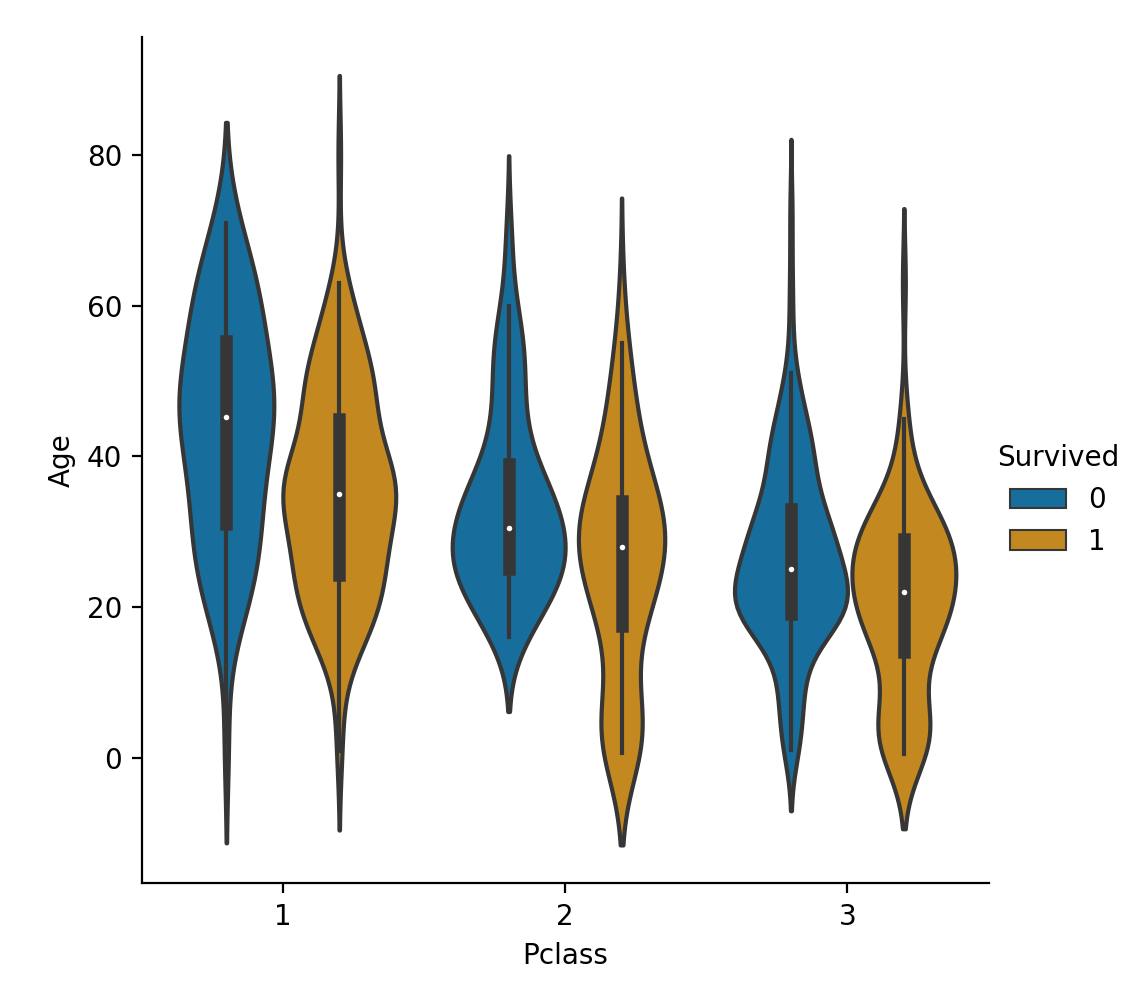

In [45]:
sns.set_palette("colorblind")
sns.catplot(x='Pclass',y='Age',hue='Survived',data=df_titanic_raw, kind="violin")

In [46]:
df_titanic_raw.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

# iloc

In [47]:
df_titanic.iloc[0:2,1:8]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket
Name,,,,,,,
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,1,female,38.0,1,0,PC 17599
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,1,female,35.0,1,0,113803


# loc

In [48]:
df_titanic.loc['Bonnell, Miss. Elizabeth', 'Fare']

26.55

In [49]:
df_titanic.loc['Bonnell, Miss. Elizabeth']

PassengerId        12
Survived            1
Pclass              1
Sex            female
                ...  
Ticket         113783
Fare            26.55
Cabin            C103
Embarked            S
Name: Bonnell, Miss. Elizabeth, Length: 11, dtype: object

In [50]:
df_titanic.loc['Bonnell, Miss. Elizabeth','Survived']= 100

In [51]:
df_titanic.loc['Bonnell, Miss. Elizabeth']

PassengerId        12
Survived          100
Pclass              1
Sex            female
                ...  
Ticket         113783
Fare            26.55
Cabin            C103
Embarked            S
Name: Bonnell, Miss. Elizabeth, Length: 11, dtype: object

In [52]:
df_titanic.loc['Bonnell, Miss. Elizabeth','Survived']= 1  # On remet la valeur comme avant 

# group-by:

In [53]:
df_titanic.groupby('Sex').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,461.818182,0.931818,1.215909,32.676136,0.534091,0.545455,89.000900
male,449.389474,0.431579,1.168421,38.451789,0.400000,0.410526,69.124343


In [54]:
df_titanic_raw.groupby('Sex').mean()['Pclass']  # attention ici on prend toutes les données, meme les manquantes...

Sex
female    2.065134
male      2.335541
Name: Pclass, dtype: float64

In [55]:
df_titanic['AgeClass'] = pd.cut(df_titanic['Age'], bins=np.arange(0,90,10)) # créer des classes / découpes.

In [56]:
df_titanic['AgeClass']

Name
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    (30, 40]
Futrelle, Mrs. Jacques Heath (Lily May Peel)           (30, 40]
McCarthy, Mr. Timothy J                                (50, 60]
Sandstrom, Miss. Marguerite Rut                         (0, 10]
                                                         ...   
Carlsson, Mr. Frans Olof                               (30, 40]
Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)          (50, 60]
Graham, Miss. Margaret Edith                           (10, 20]
Behr, Mr. Karl Howell                                  (20, 30]
Name: AgeClass, Length: 183, dtype: category
Categories (8, interval[int64]): [(0, 10] < (10, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80]]

# Cas 2:  air quality in Paris.
(Source: Airparif)


In [57]:
url = "http://josephsalmon.eu/enseignement/datasets/20080421_20160927-PA13_auto.csv"
path_target = "./20080421_20160927-PA13_auto.csv"
download(url, path_target, replace=False)

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.


'./20080421_20160927-PA13_auto.csv'

In [58]:
!head -26 ./20080421_20160927-PA13_auto.csv

#microg/m3;microg/m3 Paris 13eme
date;heure;NO2;O3
21/04/2008;1;13;74
21/04/2008;2;11;73
21/04/2008;3;13;64
21/04/2008;4;23;46
21/04/2008;5;47;24
21/04/2008;6;70;11
21/04/2008;7;70;17
21/04/2008;8;76;16
21/04/2008;9;n/d;n/d
21/04/2008;10;n/d;n/d
21/04/2008;11;n/d;n/d
21/04/2008;12;33;60
21/04/2008;13;31;61
21/04/2008;14;37;61
21/04/2008;15;20;78
21/04/2008;16;29;71
21/04/2008;17;30;70
21/04/2008;18;38;58
21/04/2008;19;52;40
21/04/2008;20;56;29
21/04/2008;21;39;40
21/04/2008;22;31;42
21/04/2008;23;29;42
21/04/2008;24;28;36


# Traitement des données temporelles et dates: 
https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

In [59]:
polution_df = pd.read_csv('20080421_20160927-PA13_auto.csv', sep=';',
                          comment='#',
                          na_values="n/d",
                          converters={'heure': str})

In [60]:
polution_df.head(12)

,date,heure,NO2,O3
0,21/04/2008,1,13.0,74.0
1,21/04/2008,2,11.0,73.0
2,21/04/2008,3,13.0,64.0
3,21/04/2008,4,23.0,46.0
...,...,...,...,...
8,21/04/2008,9,NaN,NaN
9,21/04/2008,10,NaN,NaN
10,21/04/2008,11,NaN,NaN
11,21/04/2008,12,33.0,60.0


## Preprocess the data

### <font color='red'> EXERCISE : handling missing values </font>

What is the meaning of "na_values="n/d" above?

Note that an alternative can be obtained with the command `polution_df.replace('n/d', np.nan, inplace=True)`


In [61]:
# check types
polution_df.dtypes

date      object
heure     object
NO2      float64
O3       float64
dtype: object

For more info on the object nature (inherited from numpy), see https://stackoverflow.com/questions/21018654/strings-in-a-dataframe-but-dtype-is-object

### First issue non conventional hours

In [62]:
# start by changing to integer type (e.g. int8)
polution_df['heure'] = polution_df['heure'].astype(np.int8)

# no data is from 1 to 24... not conventional so let's make it from 0 to 23
polution_df['heure'] = polution_df['heure'] - 1

# and back to strings:
polution_df['heure'] = polution_df['heure'].astype('str')

### Time processing


In [63]:
# https://www.tutorialspoint.com/python/time_strptime.htm

time_improved = pd.to_datetime(polution_df['date'] +
                               ' ' + polution_df['heure'] + ':00',
                               format='%d/%m/%Y %H:%M')

# Where d = day, m=month, Y=year, H=hour, M=minutes

In [64]:
polution_df['date'] + ' ' + polution_df['heure'] + ':00'

0         21/04/2008 0:00
1         21/04/2008 1:00
2         21/04/2008 2:00
3         21/04/2008 3:00
               ...       
73916    27/09/2016 20:00
73917    27/09/2016 21:00
73918    27/09/2016 22:00
73919    27/09/2016 23:00
Length: 73920, dtype: object

In [65]:
time_improved

0       2008-04-21 00:00:00
1       2008-04-21 01:00:00
2       2008-04-21 02:00:00
3       2008-04-21 03:00:00
                ...        
73916   2016-09-27 20:00:00
73917   2016-09-27 21:00:00
73918   2016-09-27 22:00:00
73919   2016-09-27 23:00:00
Length: 73920, dtype: datetime64[ns]

In [66]:
# create correct timing format in the dataframe
polution_df['DateTime'] = time_improved

# remove useles columns
del polution_df['heure']
del polution_df['date']

In [67]:
polution_df

,NO2,O3,DateTime
0,13.0,74.0,2008-04-21 00:00:00
1,11.0,73.0,2008-04-21 01:00:00
2,13.0,64.0,2008-04-21 02:00:00
3,23.0,46.0,2008-04-21 03:00:00
...,...,...,...
73916,85.0,5.0,2016-09-27 20:00:00
73917,75.0,9.0,2016-09-27 21:00:00
73918,64.0,15.0,2016-09-27 22:00:00
73919,57.0,14.0,2016-09-27 23:00:00


In [68]:
# visualize the data set
polution_ts = polution_df.set_index(['DateTime'])
polution_ts = polution_ts.sort_index()
polution_ts.head(12)

,NO2,O3
DateTime,,
2008-04-21 00:00:00,13.0,74.0
2008-04-21 01:00:00,11.0,73.0
2008-04-21 02:00:00,13.0,64.0
2008-04-21 03:00:00,23.0,46.0
...,...,...
2008-04-21 08:00:00,NaN,NaN
2008-04-21 09:00:00,NaN,NaN
2008-04-21 10:00:00,NaN,NaN
2008-04-21 11:00:00,33.0,60.0


In [69]:
polution_ts.describe()

,NO2,O3
count,71008.000000,71452.000000
mean,34.453414,39.610046
std,20.380702,28.837333
min,1.000000,0.000000
25%,19.000000,16.000000
50%,30.000000,38.000000
75%,46.000000,58.000000
max,167.000000,211.000000


<IPython.core.display.Javascript object>


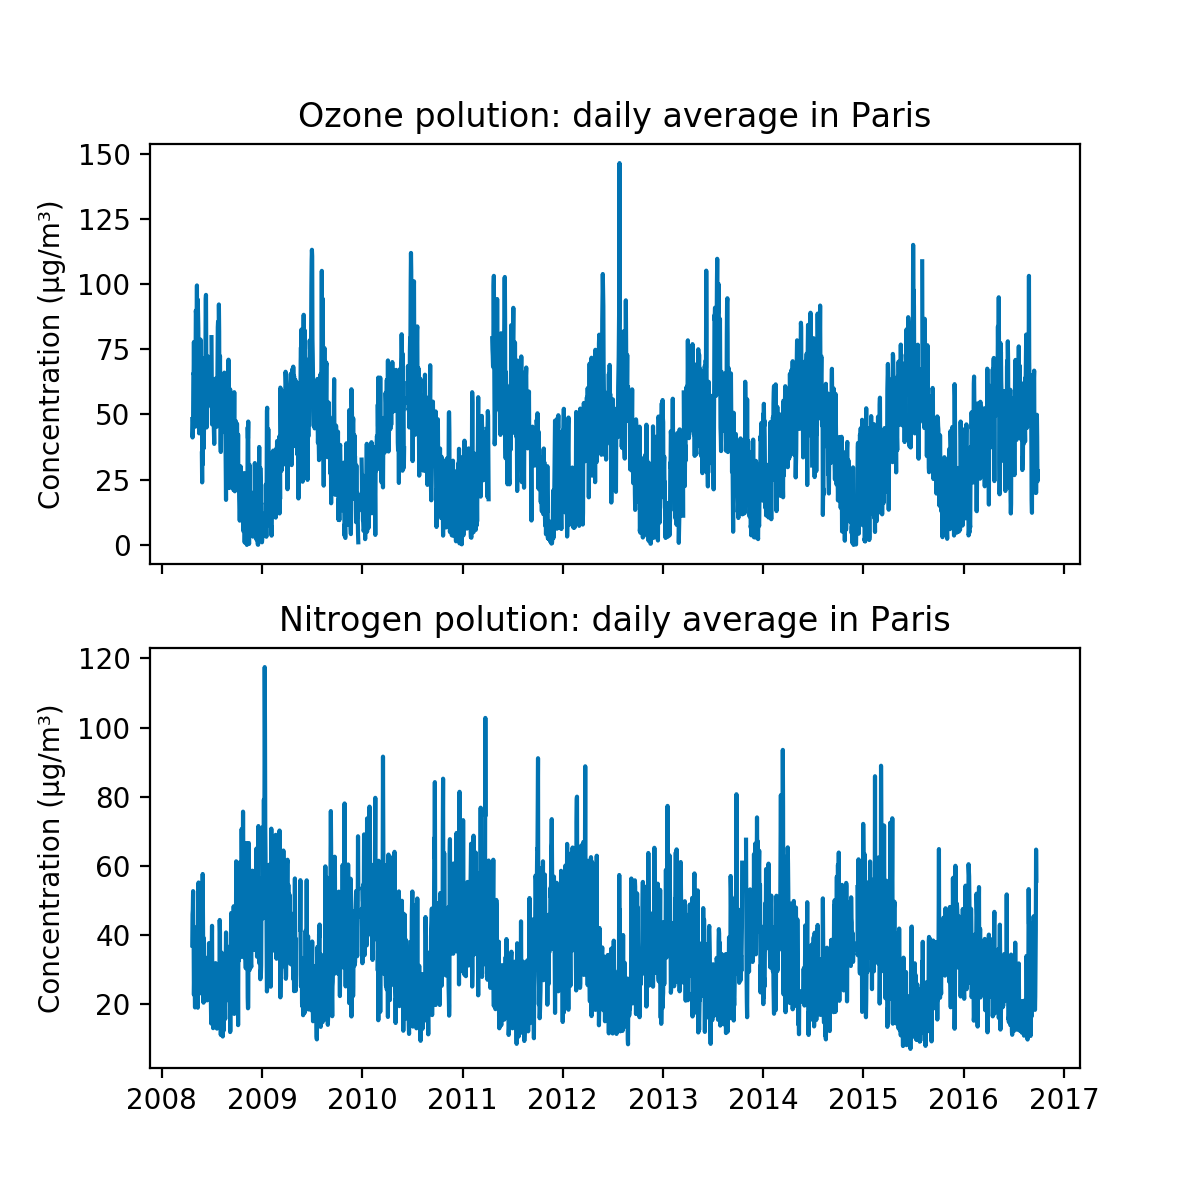

In [70]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

axes[0].plot(polution_ts['O3'].resample('d').mean())
axes[0].set_title("Ozone polution: daily average in Paris")
axes[0].set_ylabel("Concentration (µg/m³)")

axes[1].plot(polution_ts['NO2'].resample('d').mean())
axes[1].set_title("Nitrogen polution: daily average in Paris")
axes[1].set_ylabel("Concentration (µg/m³)")

plt.show()

### <font color='red'> EXERCISE : worst of the day  </font>
Provide the same plots as before, but with dayly best and worst on the same figures (use different colors)

<IPython.core.display.Javascript object>


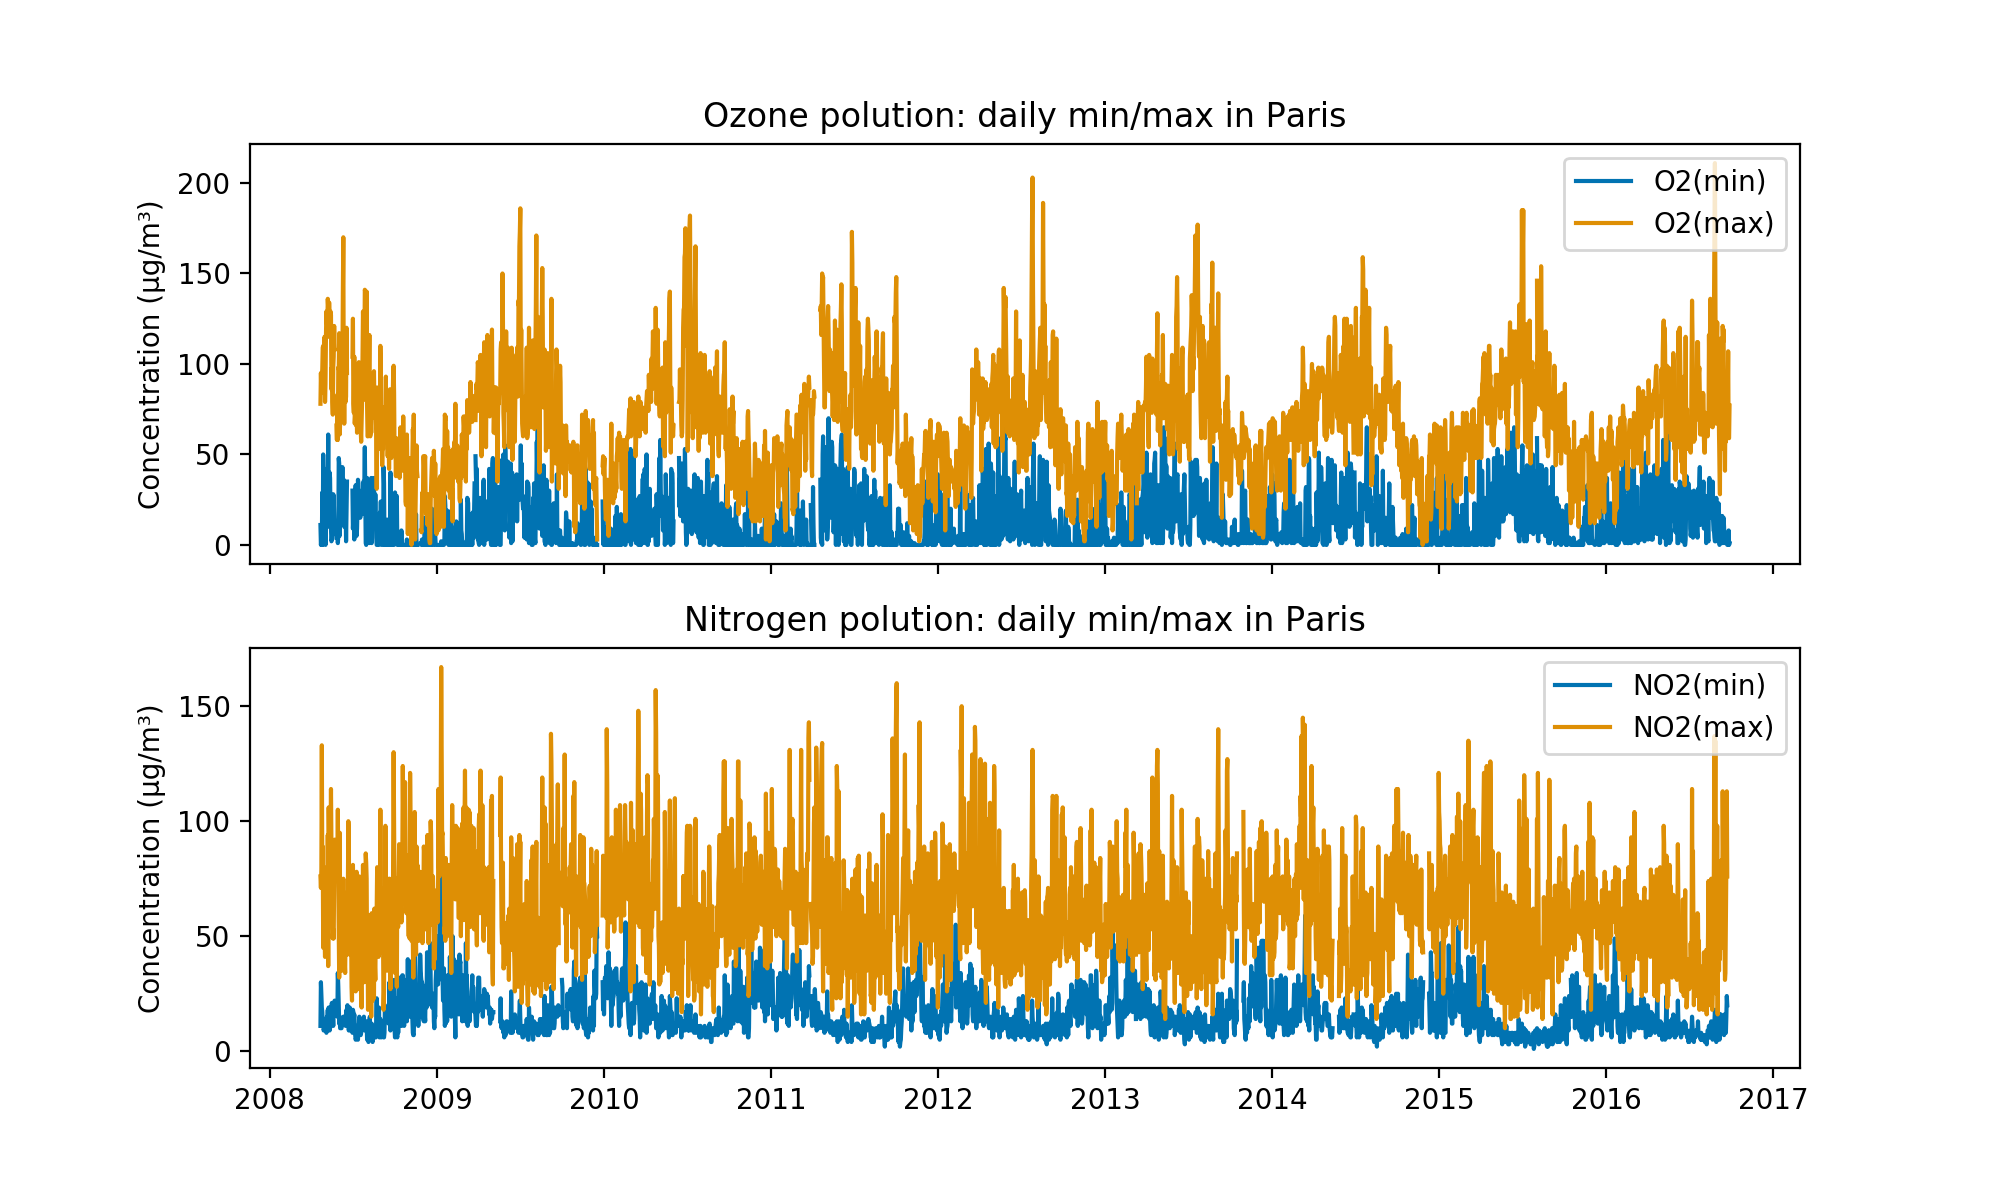

In [71]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(polution_ts['O3'].resample('d').min(), label="O2(min)")
axes[0].plot(polution_ts['O3'].resample('d').max(), label="O2(max)")
axes[0].set_title("Ozone polution: daily min/max in Paris")
axes[0].set_ylabel("Concentration (µg/m³)")
axes[0].legend(loc=1)
axes[1].plot(polution_ts['NO2'].resample('d').min(), label="NO2(min)")
axes[1].plot(polution_ts['NO2'].resample('d').max(), label="NO2(max)")

axes[1].set_title("Nitrogen polution: daily min/max in Paris")
axes[1].set_ylabel("Concentration (µg/m³)")
axes[1].legend(loc=1)

plt.show()

### Is the polution getting better along the year?

<IPython.core.display.Javascript object>


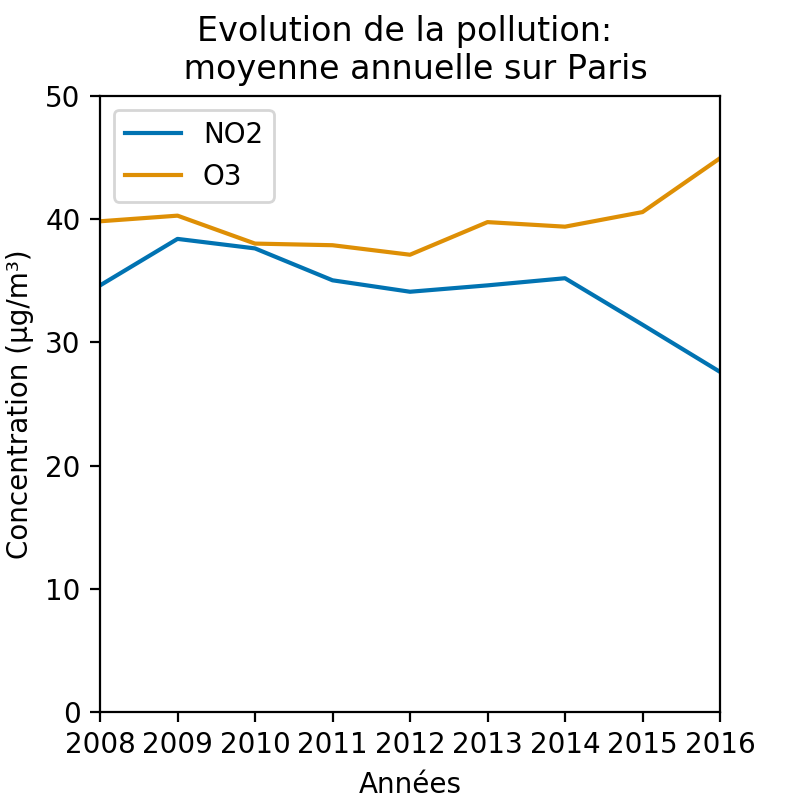

Text(0.5, 0, 'Années')

In [72]:
ax = polution_ts['2008':].resample('A').mean().plot(figsize=(4,4))  # échantillone par année (A pour Annual)
plt.ylim(0,50)
plt.title("Evolution de la pollution: \n moyenne annuelle sur Paris")
plt.ylabel("Concentration (µg/m³)")
plt.xlabel("Années")

In [73]:
# Chargement des couleurs
sns.set_palette("GnBu_d", n_colors=7)
polution_ts['weekday'] = polution_ts.index.weekday  # Monday=0, Sunday=6

# polution_ts['weekend'] = polution_ts['weekday'].isin([5, 6])

days = ['Lundi', 'Mardi', 'Mercredi',
        'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

polution_week_no2 = polution_ts.groupby(['weekday', polution_ts.index.hour])[
    'NO2'].mean().unstack(level=0)
polution_week_03 = polution_ts.groupby(['weekday', polution_ts.index.hour])[
    'O3'].mean().unstack(level=0)
plt.show()

<IPython.core.display.Javascript object>


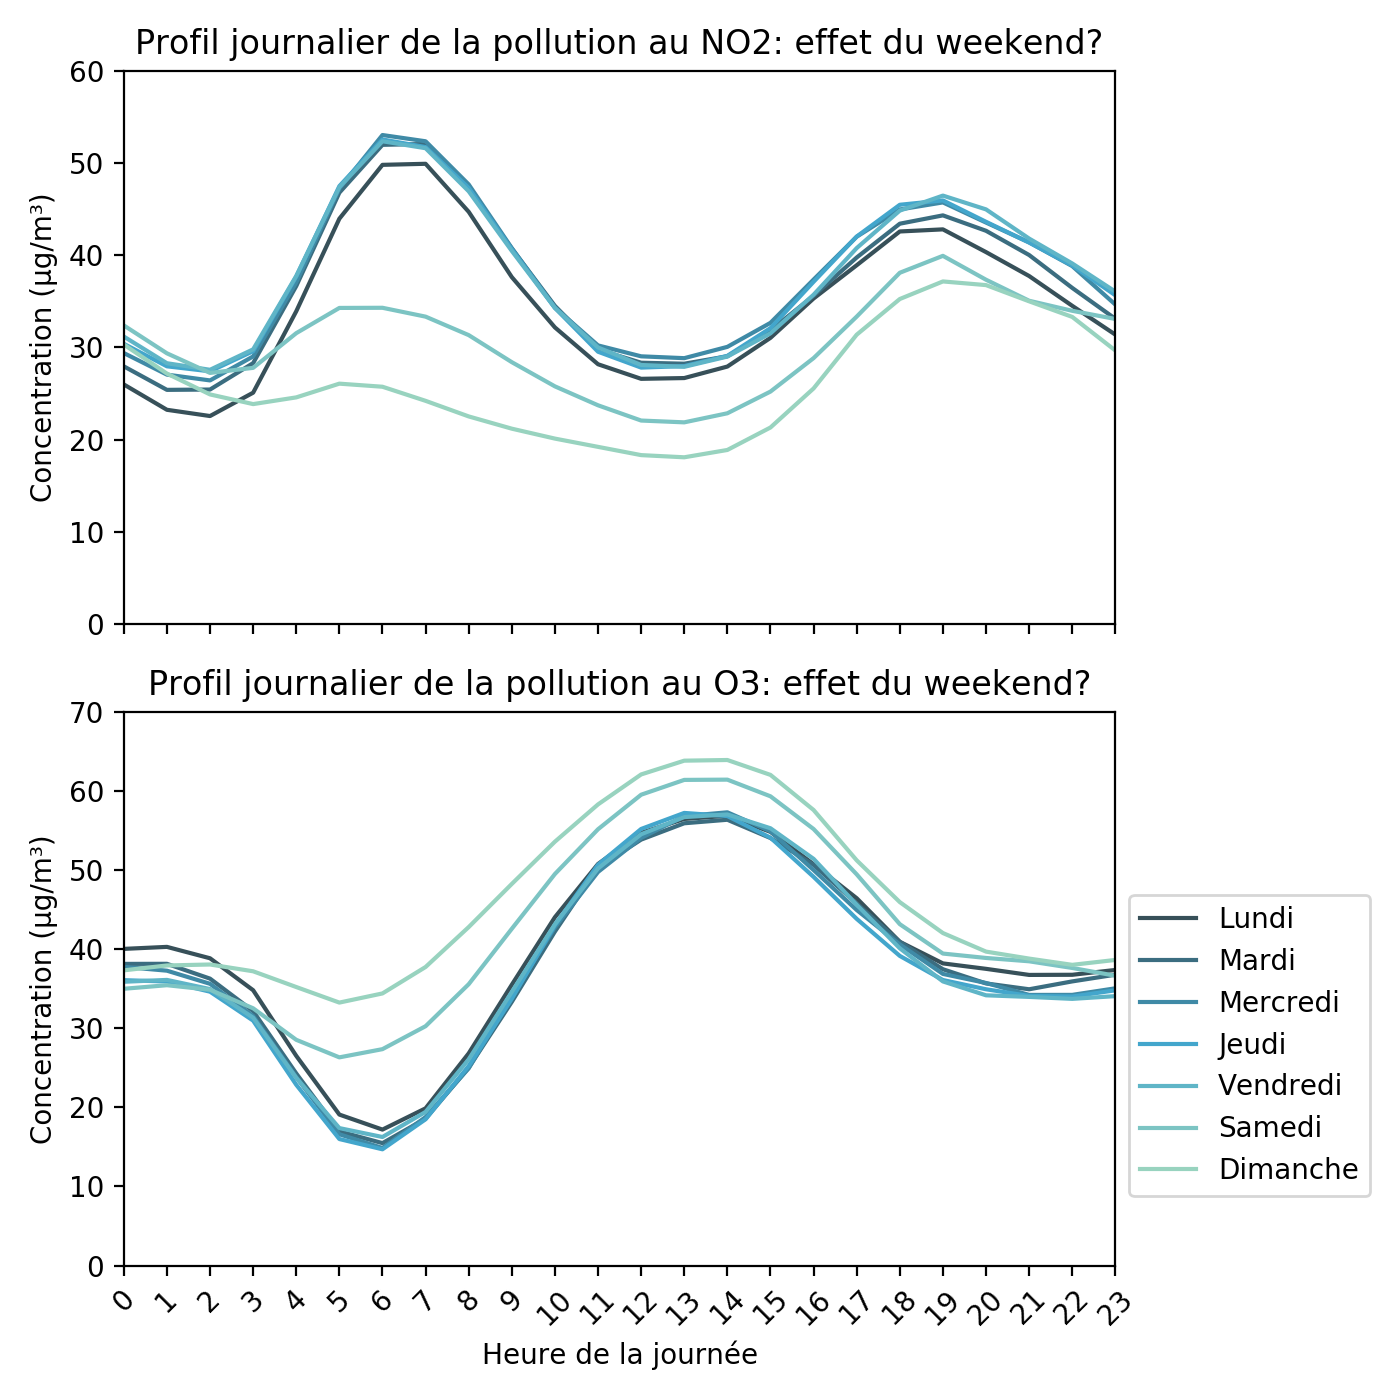

In [74]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

polution_week_no2.plot(ax=axes[0])
axes[0].set_ylabel("Concentration (µg/m³)")
axes[0].set_xlabel("Heure de la journée")
axes[0].set_title(
    "Profil journalier de la pollution au NO2: effet du weekend?")
axes[0].set_xticks(np.arange(0, 24))
axes[0].set_xticklabels(np.arange(0, 24), rotation=45)
axes[0].set_ylim(0, 60)

polution_week_03.plot(ax=axes[1])
axes[1].set_ylabel("Concentration (µg/m³)")
axes[1].set_xlabel("Heure de la journée")
axes[1].set_title("Profil journalier de la pollution au O3: effet du weekend?")
axes[1].set_xticks(np.arange(0, 24))
axes[1].set_xticklabels(np.arange(0, 24), rotation=45)
axes[1].set_ylim(0, 70)
axes[0].legend().set_visible(False)
# ax.legend()
axes[1].legend(labels=days, loc='lower left', bbox_to_anchor=(1, 0.1))

plt.tight_layout()

In [75]:
# XXX TODO quid des saisons?

In [76]:
import calendar
polution_ts['month'] = polution_ts.index.month  # Janvier=0, .... Decembre=11
polution_ts['month'] = polution_ts['month'].apply(lambda x: calendar.month_abbr[x])
polution_ts.head()

,NO2,O3,weekday,month
DateTime,,,,
2008-04-21 00:00:00,13.0,74.0,0,Apr
2008-04-21 01:00:00,11.0,73.0,0,Apr
2008-04-21 02:00:00,13.0,64.0,0,Apr
2008-04-21 03:00:00,23.0,46.0,0,Apr
2008-04-21 04:00:00,47.0,24.0,0,Apr


In [77]:
days = []

polution_month_no2 = polution_ts.groupby(['month', polution_ts.index.hour])[
    'NO2'].mean().unstack(level=0)
polution_month_03 = polution_ts.groupby(['month', polution_ts.index.hour])[
    'O3'].mean().unstack(level=0)

<IPython.core.display.Javascript object>


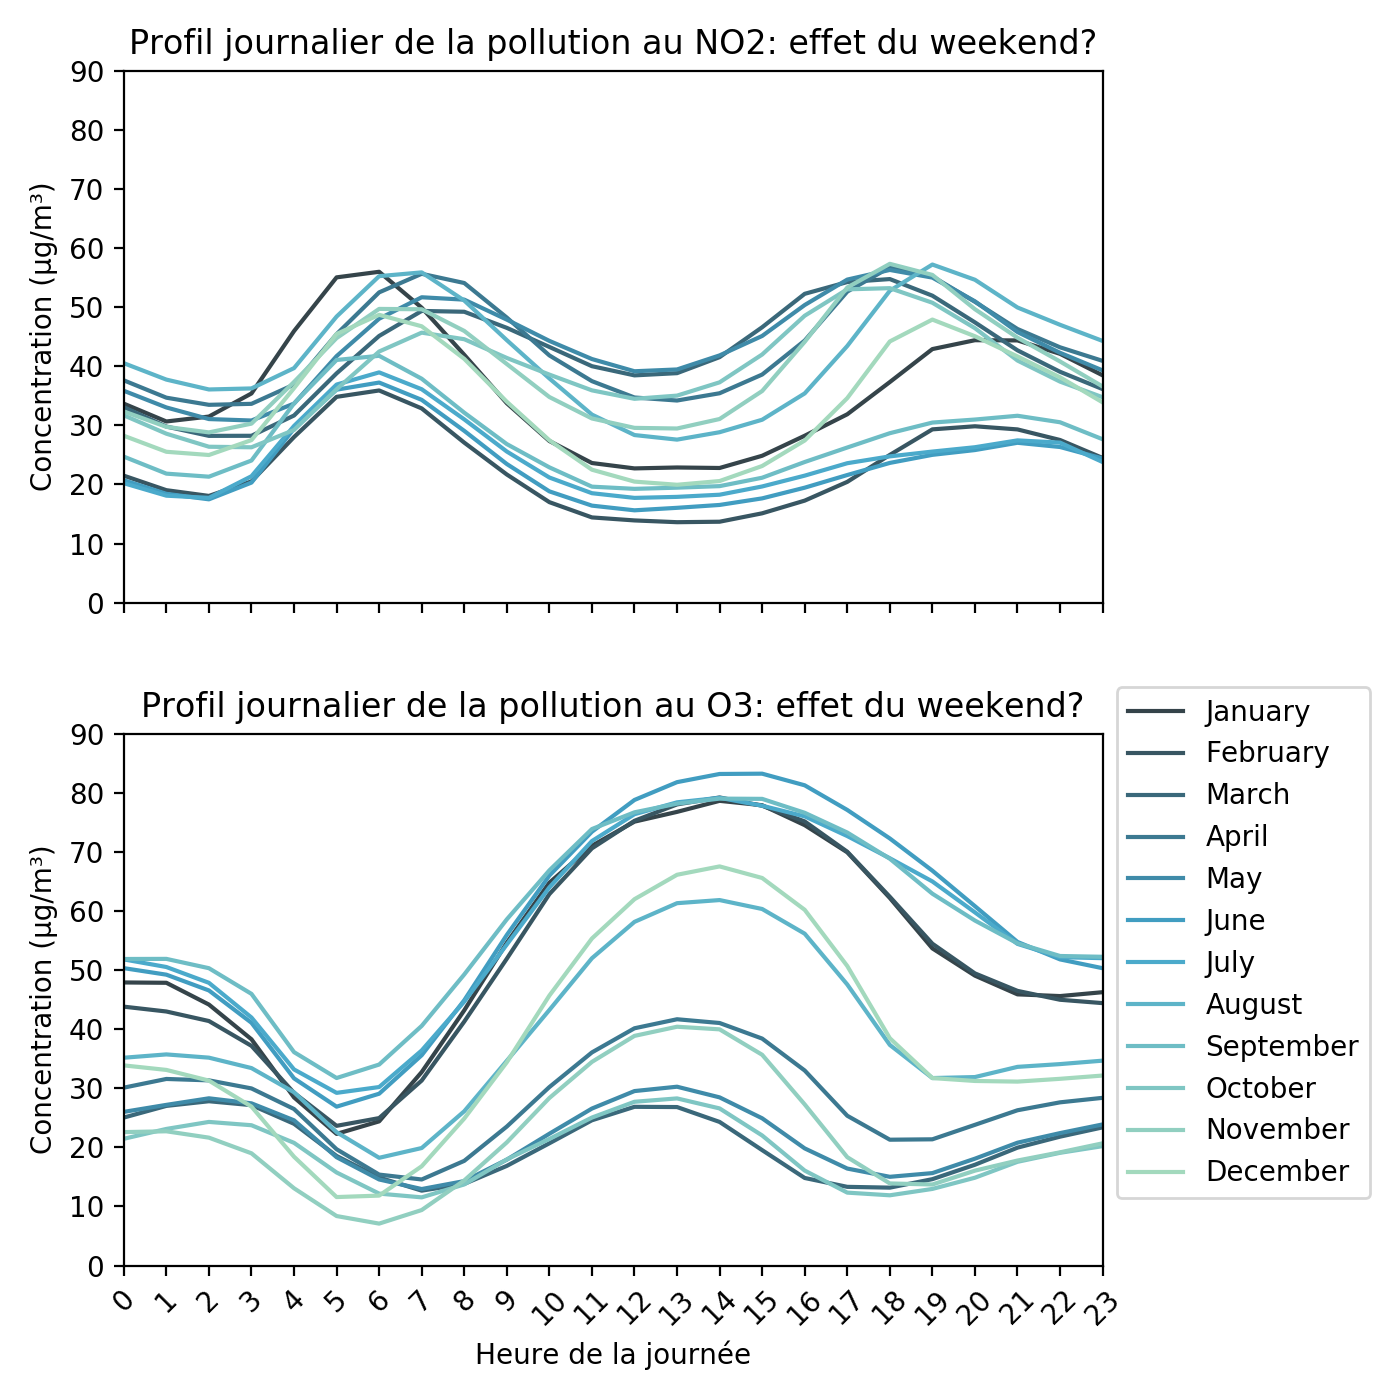

In [78]:
sns.set_palette("GnBu_d", n_colors=12)

fig, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

polution_month_no2.plot(ax=axes[0])
axes[0].set_ylabel("Concentration (µg/m³)")
axes[0].set_xlabel("Heure de la journée")
axes[0].set_title(
    "Profil journalier de la pollution au NO2: effet du weekend?")
axes[0].set_xticks(np.arange(0, 24))
axes[0].set_xticklabels(np.arange(0, 24), rotation=45)
axes[0].set_ylim(0, 90)

polution_month_03.plot(ax=axes[1])
axes[1].set_ylabel("Concentration (µg/m³)")
axes[1].set_xlabel("Heure de la journée")
axes[1].set_title("Profil journalier de la pollution au O3: effet du weekend?")
axes[1].set_xticks(np.arange(0, 24))
axes[1].set_xticklabels(np.arange(0, 24), rotation=45)
axes[1].set_ylim(0, 90)
axes[0].legend().set_visible(False)
# ax.legend()
axes[1].legend(labels=calendar.month_name[1:], loc='lower left', bbox_to_anchor=(1, 0.1))

plt.tight_layout()

# Your turn: explore the bike accident dataset

https://www.data.gouv.fr/fr/datasets/accidents-de-velo-en-france/

Possible visualisation
https://koumoul.com/en/datasets/accidents-velos

In [79]:
url = "https://www.data.gouv.fr/fr/datasets/r/ab84353b-498b-4ef5-9a02-a6403f2ead96"
path_target = "./bicycle_db.csv"
download(url, path_target, replace=False)

Replace is False and data exists, so doing nothing. Use replace==True to re-download the data.


'./bicycle_db.csv'

In [80]:
# df: data frame
df_bikes = pd.read_csv("bicycle_db.csv",na_values="", converters={'data': str, 'heure': str})

/home/jo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [81]:
!head -5 ./bicycle_db.csv

"identifiant accident","date","mois","jour","heure","departement","commune","lat","lon","en agglomeration","type intersection","type collision","luminosite","conditions atmosperiques","type route","circulation","nb voies","profil long route","trace plan route","largeur TPC","largeur route","etat surface","amenagement","situation","categorie usager","gravite accident","sexe","age","motif deplacement","existence securite","usage securite","obstacle fixe heurte","obstacle mobile heurte","localisation choc","manoeuvre avant accident","identifiant vehicule","type autres vehicules","manoeuvre autres vehicules","nombre autres vehicules"
"200500000030","2005-01-13","01 - janvier","3 - jeudi","19","62","62331","50.3","2.84","oui","Hors intersection","Deux véhicules - par le coté","Nuit avec éclairage public allumé","Normale","Route Départementale",,,,"Partie rectiligne",,"50","normale",,"Sur chaussée","Conducteur","1 - Blessé léger","M","57-58","Promenade - loisirs",,,,"Véhicule","Côté gauche",

In [82]:
pd.options.display.max_columns = 40
df_bikes.head()

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
0,200500000030,2005-01-13,01 - janvier,3 - jeudi,19,62,62331,50.300,2.840,oui,Hors intersection,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Normale,Route Départementale,NaN,NaN,NaN,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,57-58,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Côté gauche,Changeant de file à gauche,200500000030B02,Transport en commun,Dépassant à gauche,1.0
1,200500000034,2005-01-19,01 - janvier,2 - mercredi,10,62,62022,0.000,0.000,non,Hors intersection,Deux véhicules - frontale,Plein jour,Temps éblouissant,Route Départementale,NaN,NaN,Plat,En courbe à droite,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,M,19-20,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500000034B02,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...",Tournant à gauche,1.0
2,200500000078,2005-01-26,01 - janvier,2 - mercredi,13,02,02173,0.000,0.000,non,Autre intersection,Deux véhicules - par le coté,Plein jour,Normale,Route Départementale,NaN,2.0,Pente,Partie rectiligne,NaN,NaN,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,70-71,Promenade - loisirs,Casque,Non,NaN,Véhicule,Avant,Sans changement de direction,200500000078B02,VL seul,Tournant à gauche,1.0
3,200500000093,2005-01-03,01 - janvier,0 - lundi,13,02,02810,49.255,3.094,oui,Hors intersection,Deux véhicules - frontale,Plein jour,Normale,Route Départementale,NaN,NaN,Plat,En courbe à gauche,NaN,52.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,F,50-51,Utilisation professionnelle,NaN,NaN,NaN,Véhicule,Avant gauche,Manœuvre d’évitement,200500000093B02,VL seul,Manœuvre d’évitement,1.0
4,200500000170,2005-01-29,01 - janvier,5 - samedi,18,76,76196,0.000,0.000,non,Hors intersection,Deux véhicules - par l’arrière,Nuit sans éclairage public,Normale,Route Départementale,NaN,2.0,Plat,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,73-74,Promenade - loisirs,Autre,Oui,NaN,Véhicule,Arrière,"Même sens, même file",200500000170A01,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...","Même sens, même file",1.0


In [83]:
df_bikes['existence securite'].unique()

array([nan, 'Casque', 'Autre', 'Equipement réfléchissant', 'Ceinture',
       'Dispositif enfants'], dtype=object)

In [84]:
df_bikes['gravite accident'].unique()

array(['1 - Blessé léger', '2 - Blessé hospitalisé', '3 - Tué',
       '0 - Indemne'], dtype=object)

### Handle missing values in `heure`

In [85]:
df_bikes['date'].hasnans

False

In [86]:
df_bikes['heure'].hasnans

False

In [87]:
pd.options.display.max_rows = 20
df_bikes.iloc[400:402]

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
400,200500008935,2005-02-13,02 - février,6 - dimanche,,75,75018,0.0,0.0,oui,Intersection en X,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Vent fort - tempête,Voie Communale,NaN,4.0,Plat,Partie rectiligne,NaN,120.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,32-33,Domicile - travail,Casque,Oui,NaN,Véhicule,Avant gauche,"Dans le couloir bus, dans le même sens",200500008935B01,VL seul,Tournant a droite,1.0
401,200500008941,2005-02-14,02 - février,0 - lundi,15,75,75007,0.0,0.0,oui,Hors intersection,Deux véhicules - par le coté,Plein jour,Normale,Voie Communale,NaN,4.0,Plat,Partie rectiligne,NaN,120.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,F,21-22,Promenade - loisirs,Casque,Oui,NaN,Véhicule,Avant droit,Sans changement de direction,200500008941A01,VL seul,En s’insérant,1.0


In [88]:
# remove missing hours cases by np.nan
df_bikes['heure']=df_bikes['heure'].replace('', np.nan)
df_bikes.iloc[400:402]

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
400,200500008935,2005-02-13,02 - février,6 - dimanche,NaN,75,75018,0.0,0.0,oui,Intersection en X,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Vent fort - tempête,Voie Communale,NaN,4.0,Plat,Partie rectiligne,NaN,120.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,32-33,Domicile - travail,Casque,Oui,NaN,Véhicule,Avant gauche,"Dans le couloir bus, dans le même sens",200500008935B01,VL seul,Tournant a droite,1.0
401,200500008941,2005-02-14,02 - février,0 - lundi,15,75,75007,0.0,0.0,oui,Hors intersection,Deux véhicules - par le coté,Plein jour,Normale,Voie Communale,NaN,4.0,Plat,Partie rectiligne,NaN,120.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,F,21-22,Promenade - loisirs,Casque,Oui,NaN,Véhicule,Avant droit,Sans changement de direction,200500008941A01,VL seul,En s’insérant,1.0


In [89]:
df_bikes.dropna(subset=['heure'], inplace=True)
df_bikes.iloc[399:402]

,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
399,200500008875,2005-02-10,02 - février,3 - jeudi,15,75,75016,0.0,0.0,oui,Hors intersection,Deux véhicules - par l’arrière,Plein jour,Normale,Voie Communale,NaN,4.0,Plat,Partie rectiligne,NaN,120.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,53-54,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Arrière,Sans changement de direction,200500008875B01,Bicyclette,Sans changement de direction,1.0
401,200500008941,2005-02-14,02 - février,0 - lundi,15,75,75007,0.0,0.0,oui,Hors intersection,Deux véhicules - par le coté,Plein jour,Normale,Voie Communale,NaN,4.0,Plat,Partie rectiligne,NaN,120.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,F,21-22,Promenade - loisirs,Casque,Oui,NaN,Véhicule,Avant droit,Sans changement de direction,200500008941A01,VL seul,En s’insérant,1.0
402,200500008961,2005-02-11,02 - février,4 - vendredi,12,75,75005,0.0,0.0,oui,Intersection en T,Deux véhicules - par le coté,Plein jour,Normale,Voie Communale,NaN,2.0,Plat,Partie rectiligne,NaN,60.0,mouillée,NaN,Sur chaussée,Conducteur,1 - Blessé léger,F,27-28,Autre,Casque,Oui,NaN,Véhicule,Avant gauche,Sans changement de direction,200500008961A01,Scooter immatriculé,Sans changement de direction,1.0


### <font color='red'> EXERCISE : Dates?  </font>
Can you find the starting day and the ending day of the study automatically? 
hint sort the data.
You can sort the data by time, , say with df.sort('Time') )

In [90]:
df_bikes['date'] + ' ' + df_bikes['heure'] + ':00'

0        2005-01-13 19:00
1        2005-01-19 10:00
2        2005-01-26 13:00
3        2005-01-03 13:00
4        2005-01-29 18:00
5        2005-01-23 18:00
6        2005-01-04 16:00
7        2005-01-05 17:00
8        2005-01-08 10:00
9        2005-01-13 15:00
               ...       
65971    2018-08-09 18:00
65972    2018-02-16 11:00
65973    2018-02-16 19:00
65974     2018-02-25 8:00
65975    2018-03-08 19:00
65976     2018-09-27 8:00
65977    2018-03-21 18:00
65978    2018-03-31 17:00
65979    2018-03-31 17:00
65980    2018-07-31 11:00
Length: 65515, dtype: object

In [91]:
# ADAPT OLD to create the df_bikes['Time']

time_improved = pd.to_datetime(df_bikes['date'] +
                               ' ' + df_bikes['heure'] + ':00',
                               format='%Y-%m-%d %H:%M')

# Where d = day, m=month, Y=year, H=hour, M=minutes
# create correct timing format in the dataframe


In [92]:
df_bikes['Time'] = time_improved
df_bikes.set_index('Time',inplace=True)
# remove useles columns
del df_bikes['heure']
del df_bikes['date']


In [93]:
df_bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65515 entries, 2005-01-13 19:00:00 to 2018-07-31 11:00:00
Data columns (total 37 columns):
identifiant accident          65515 non-null int64
mois                          65515 non-null object
jour                          65515 non-null object
departement                   65515 non-null object
commune                       65515 non-null object
lat                           65515 non-null float64
lon                           65249 non-null float64
en agglomeration              65515 non-null object
type intersection             65513 non-null object
type collision                65511 non-null object
luminosite                    65515 non-null object
conditions atmosperiques      65512 non-null object
type route                    65504 non-null object
circulation                   143 non-null object
nb voies                      57417 non-null float64
profil long route             60966 non-null object
trace plan route        

In [94]:
df_bikes_partial = df_bikes[['gravite accident', 'existence securite', 'age', 'sexe']]
df_bikes_partial['existence securite'] = df_bikes_partial['existence securite'].replace(np.nan, "Inconnu")
df_bikes_partial.dropna(inplace=True)

/home/jo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### <font color='red'> EXERCISE : Is the helmet saving your life?  </font>
Peform an analysis so that you can check the benefit or not of wearing helmet to save your life.
Beware preprocessing needed to use `pd.crosstab`,  `pivot_table` to avoid issues.

In [95]:
group = df_bikes_partial.pivot_table(columns='existence securite',index=['gravite accident','sexe'], aggfunc={'age': 'count'}, margins=True)
group

age                                       \
existence securite             Autre   Casque Ceinture Dispositif enfants   
gravite accident       sexe                                                 
0 - Indemne            F       187.0    298.0      8.0                1.0   
                       M      1121.0   1952.0     47.0                6.0   
1 - Blessé léger       F      3949.0   5143.0     48.0               21.0   
                       M      9180.0  13892.0    171.0               52.0   
2 - Blessé hospitalisé F      1409.0   1977.0    236.0                9.0   
                       M      4022.0   9241.0    781.0               24.0   
3 - Tué                F        87.0    164.0     32.0                NaN   
                       M       291.0   1062.0    117.0                3.0   
All                          20246.0  33729.0   1440.0              116.0   

                                                                     
existence securite          Equipement réfléchissant Inconnu    All  
gravite accident       sexe                                          
0 - Indemne            F                        33.0    69.0    596  
                       M                       189.0   274.0   3589  
1 - Blessé léger       F                       815.0   781.0  10757  
                       M                      1912.0  1559.0  26766  
2 - Blessé hospitalisé F                       310.0   582.0   4523  
                       M                      1147.0  1757.0  16972  
3 - Tué                F                        37.0    74.0    394  
                       M                       160.0   259.0   1892  
All                                           4603.0  5355.0  65489

In [109]:
# pd.crosstab?
pd.crosstab(df_bikes_partial['existence securite'], df_bikes_partial['gravite accident'], normalize='index') *100


gravite accident,0 - Indemne,1 - Blessé léger,2 - Blessé hospitalisé,3 - Tué
existence securite,,,,
Autre,6.460535,64.847377,26.825052,1.867035
Casque,6.670817,56.435115,33.259213,3.634854
Ceinture,3.819444,15.208333,70.625000,10.347222
Dispositif enfants,6.034483,62.931034,28.448276,2.586207
Equipement réfléchissant,4.822942,59.243971,31.653270,4.279818
Inconnu,6.405229,43.697479,43.678805,6.218487


In [110]:
pd.crosstab(df_bikes_partial['existence securite'], df_bikes_partial['gravite accident'], values = df_bikes_partial['age'], aggfunc='count', normalize='index') *100


gravite accident,0 - Indemne,1 - Blessé léger,2 - Blessé hospitalisé,3 - Tué
existence securite,,,,
Autre,6.460535,64.847377,26.825052,1.867035
Casque,6.670817,56.435115,33.259213,3.634854
Ceinture,3.819444,15.208333,70.625000,10.347222
Dispositif enfants,6.034483,62.931034,28.448276,2.586207
Equipement réfléchissant,4.822942,59.243971,31.653270,4.279818
Inconnu,6.405229,43.697479,43.678805,6.218487


### <font color='red'> EXERCISE : Are men and women dying equally on a bike?  </font>
Peform an analysis to check any difference between men and woman survival on a bike?

In [113]:
idx_dead = df_bikes['gravite accident']=='3 - Tué'
df_deads = df_bikes[idx_dead]
df_gravite = df_deads.groupby('sexe').size() / idx_dead.sum()
df_gravite

sexe
F    0.172278
M    0.827722
dtype: float64

In [114]:
df_bikes.groupby('sexe').size()  / df_bikes.shape[0]

sexe
F    0.248477
M    0.751523
dtype: float64

In [99]:
pd.crosstab(df_bikes_partial['sexe'], df_bikes_partial['gravite accident'], values = df_bikes_partial['age'], aggfunc='count', normalize='columns',margins=True)*100

gravite accident,0 - Indemne,1 - Blessé léger,2 - Blessé hospitalisé,3 - Tué,All
sexe,,,,,
F,14.241338,28.66775,21.042103,17.235346,24.843867
M,85.758662,71.33225,78.957897,82.764654,75.156133


### To conclude:
some information on the level of bike practice by men/women is missing... though

### <font color='red'> EXERCISE : Accident during the week?  </font>
Peform an analysis to check when the accidents are occuring during the week.

In [115]:
df_bikes

,identifiant accident,mois,jour,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules,weekday,month
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-01-13 19:00:00,200500000030,01 - janvier,3 - jeudi,62,62331,50.30000,2.84000,oui,Hors intersection,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Normale,Route Départementale,NaN,NaN,NaN,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,57-58,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Côté gauche,Changeant de file à gauche,200500000030B02,Transport en commun,Dépassant à gauche,1.0,3,Jan
2005-01-19 10:00:00,200500000034,01 - janvier,2 - mercredi,62,62022,0.00000,0.00000,non,Hors intersection,Deux véhicules - frontale,Plein jour,Temps éblouissant,Route Départementale,NaN,NaN,Plat,En courbe à droite,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,M,19-20,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500000034B02,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...",Tournant à gauche,1.0,2,Jan
2005-01-26 13:00:00,200500000078,01 - janvier,2 - mercredi,02,02173,0.00000,0.00000,non,Autre intersection,Deux véhicules - par le coté,Plein jour,Normale,Route Départementale,NaN,2.0,Pente,Partie rectiligne,NaN,NaN,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,70-71,Promenade - loisirs,Casque,Non,NaN,Véhicule,Avant,Sans changement de direction,200500000078B02,VL seul,Tournant à gauche,1.0,2,Jan
2005-01-03 13:00:00,200500000093,01 - janvier,0 - lundi,02,02810,49.25500,3.09400,oui,Hors intersection,Deux véhicules - frontale,Plein jour,Normale,Route Départementale,NaN,NaN,Plat,En courbe à gauche,NaN,52.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,F,50-51,Utilisation professionnelle,NaN,NaN,NaN,Véhicule,Avant gauche,Manœuvre d’évitement,200500000093B02,VL seul,Manœuvre d’évitement,1.0,0,Jan
2005-01-29 18:00:00,200500000170,01 - janvier,5 - samedi,76,76196,0.00000,0.00000,non,Hors intersection,Deux véhicules - par l’arrière,Nuit sans éclairage public,Normale,Route Départementale,NaN,2.0,Plat,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,73-74,Promenade - loisirs,Autre,Oui,NaN,Véhicule,Arrière,"Même sens, même file",200500000170A01,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...","Même sens, même file",1.0,5,Jan
2005-01-23 18:00:00,200500000246,01 - janvier,6 - dimanche,35,35207,0.00000,0.00000,oui,Giratoire,Deux véhicules - frontale,Plein jour,Normale,Route Départementale,NaN,NaN,Plat,NaN,NaN,60.0,normale,Carrefour aménagé,Sur chaussée,Conducteur,2 - Blessé hospitalisé,M,45-46,Promenade - loisirs,Casque,Oui,NaN,Véhicule,Côté droit,Sans changement de direction,200500000246B02,VL seul,NaN,1.0,6,Jan
2005-01-04 16:00:00,200500000260,01 - janvier,1 - mardi,22,22143,48.59000,-2.30000,oui,Intersection en X,Deux véhicules - frontale,Plein jour,Normale,Voie Communale,NaN,NaN,Pente,Partie rectiligne,NaN,NaN,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,M,11-12,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Avant,A contresens,200500000260B02,VL seul,Sans changement de direction,1.0,1,Jan
2005-01-05 17:00:00,200500000273,01 - janvier,2 - mercredi,29,29069,0.00000,0.00000,oui,Hors intersection,Deux véhicules - par le coté,Plein jour,Normale,Voie Communale,NaN,2.0,Plat,Partie rectiligne,NaN,60.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,10-11,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Avant,En s’insérant,200500000273B02,VL seul,Sans changement de direction,1.0,2,Jan
2005-01-08 10:00

<IPython.core.display.Javascript object>


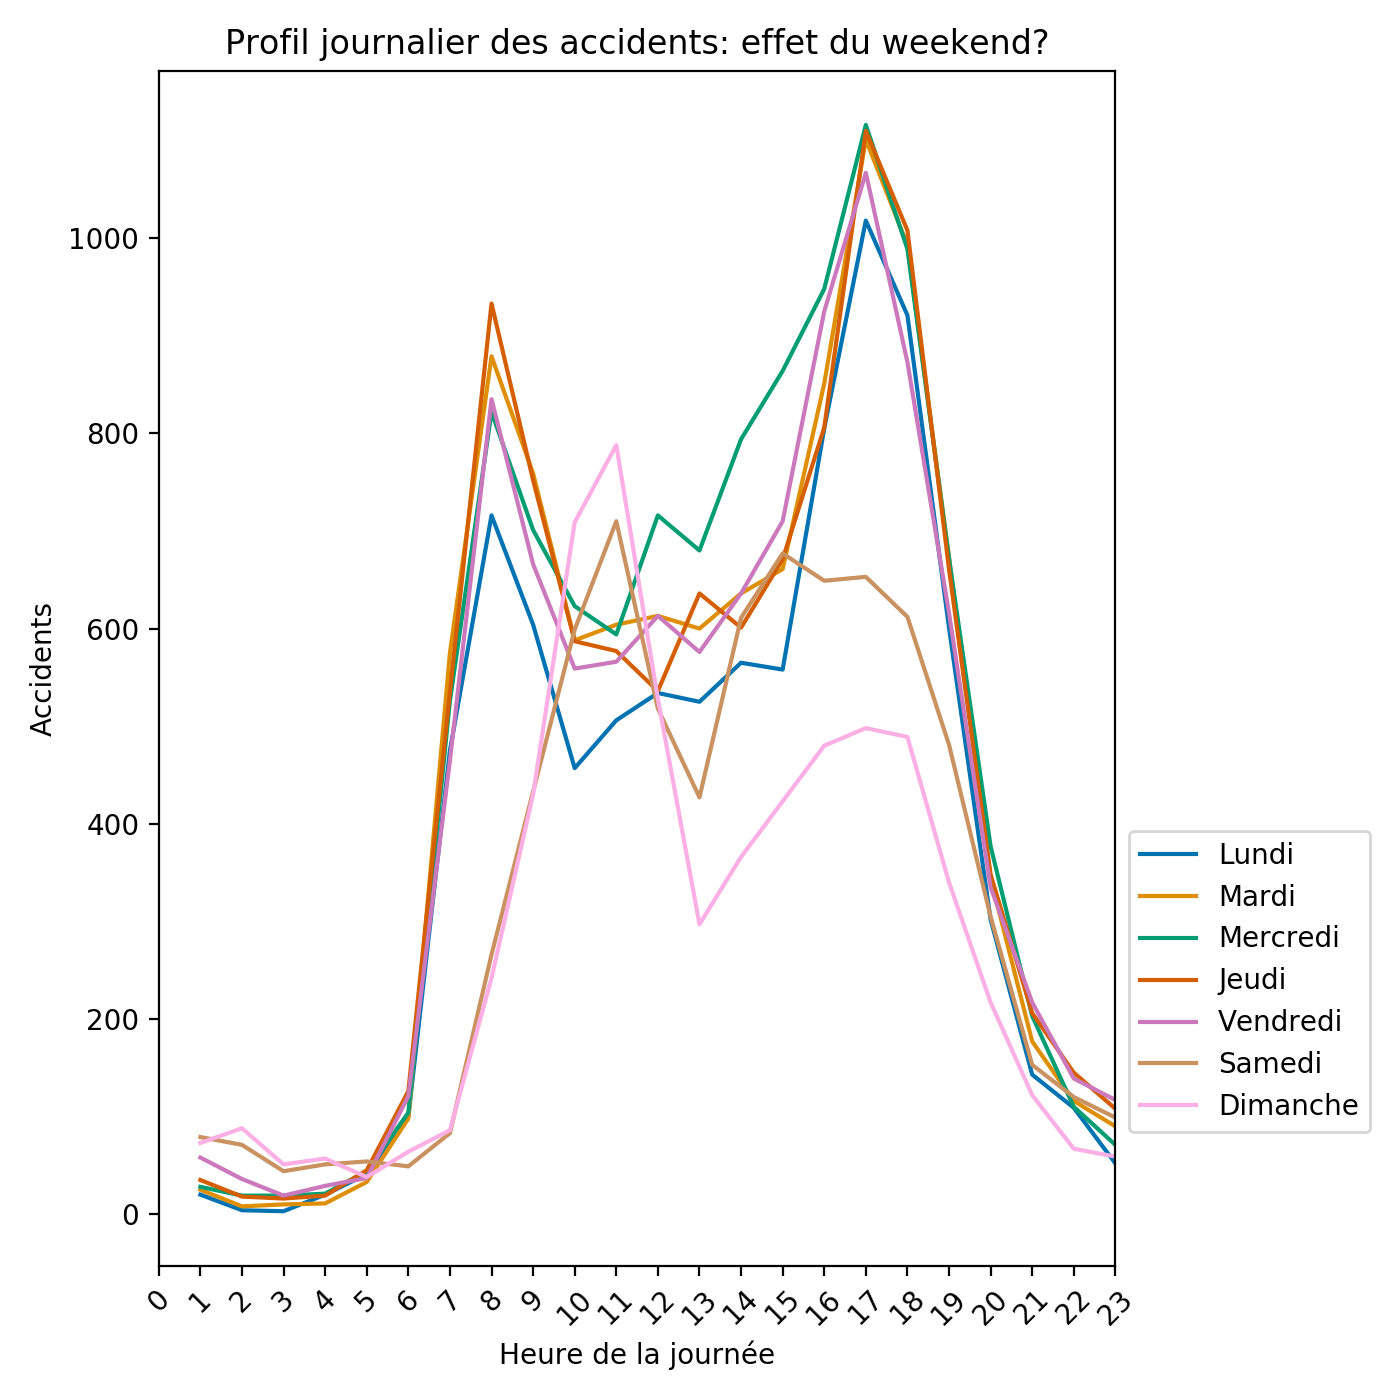

In [100]:
# Chargement des couleurs
sns.set_palette("colorblind", n_colors=7)
df_bikes['weekday'] = df_bikes.index.weekday  # Monday=0, Sunday=6

days = ['Lundi', 'Mardi', 'Mercredi',
        'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

accidents_week = df_bikes.groupby(['weekday', df_bikes.index.hour])[
    'sexe'].count().unstack(level=0)

fig, axes = plt.subplots(1, 1, figsize=(7, 7))


accidents_week.plot(ax=axes)
axes.set_ylabel("Accidents")
axes.set_xlabel("Heure de la journée")
axes.set_title(
    "Profil journalier des accidents: effet du weekend?")
axes.set_xticks(np.arange(0, 24))
axes.set_xticklabels(np.arange(0, 24), rotation=45)
# axes.set_ylim(0, 6)
axes.legend(labels=days, loc='lower left', bbox_to_anchor=(1, 0.1))

plt.tight_layout()

In [118]:
df_bikes.groupby(['weekday', df_bikes.index.hour])[
    'sexe'].count()

weekday  Time
0        1        20
         2         4
         3         3
         4        20
         5        41
         6       100
         7       475
         8       716
         9       604
         10      457
                ... 
6        14      366
         15      423
         16      480
         17      498
         18      489
         19      340
         20      217
         21      122
         22       67
         23       59
Name: sexe, Length: 161, dtype: int64

### <font color='red'> EXERCISE : Accident during the year?  </font>
Peform an analysis to check when the accidents are occuring during the week.

<IPython.core.display.Javascript object>


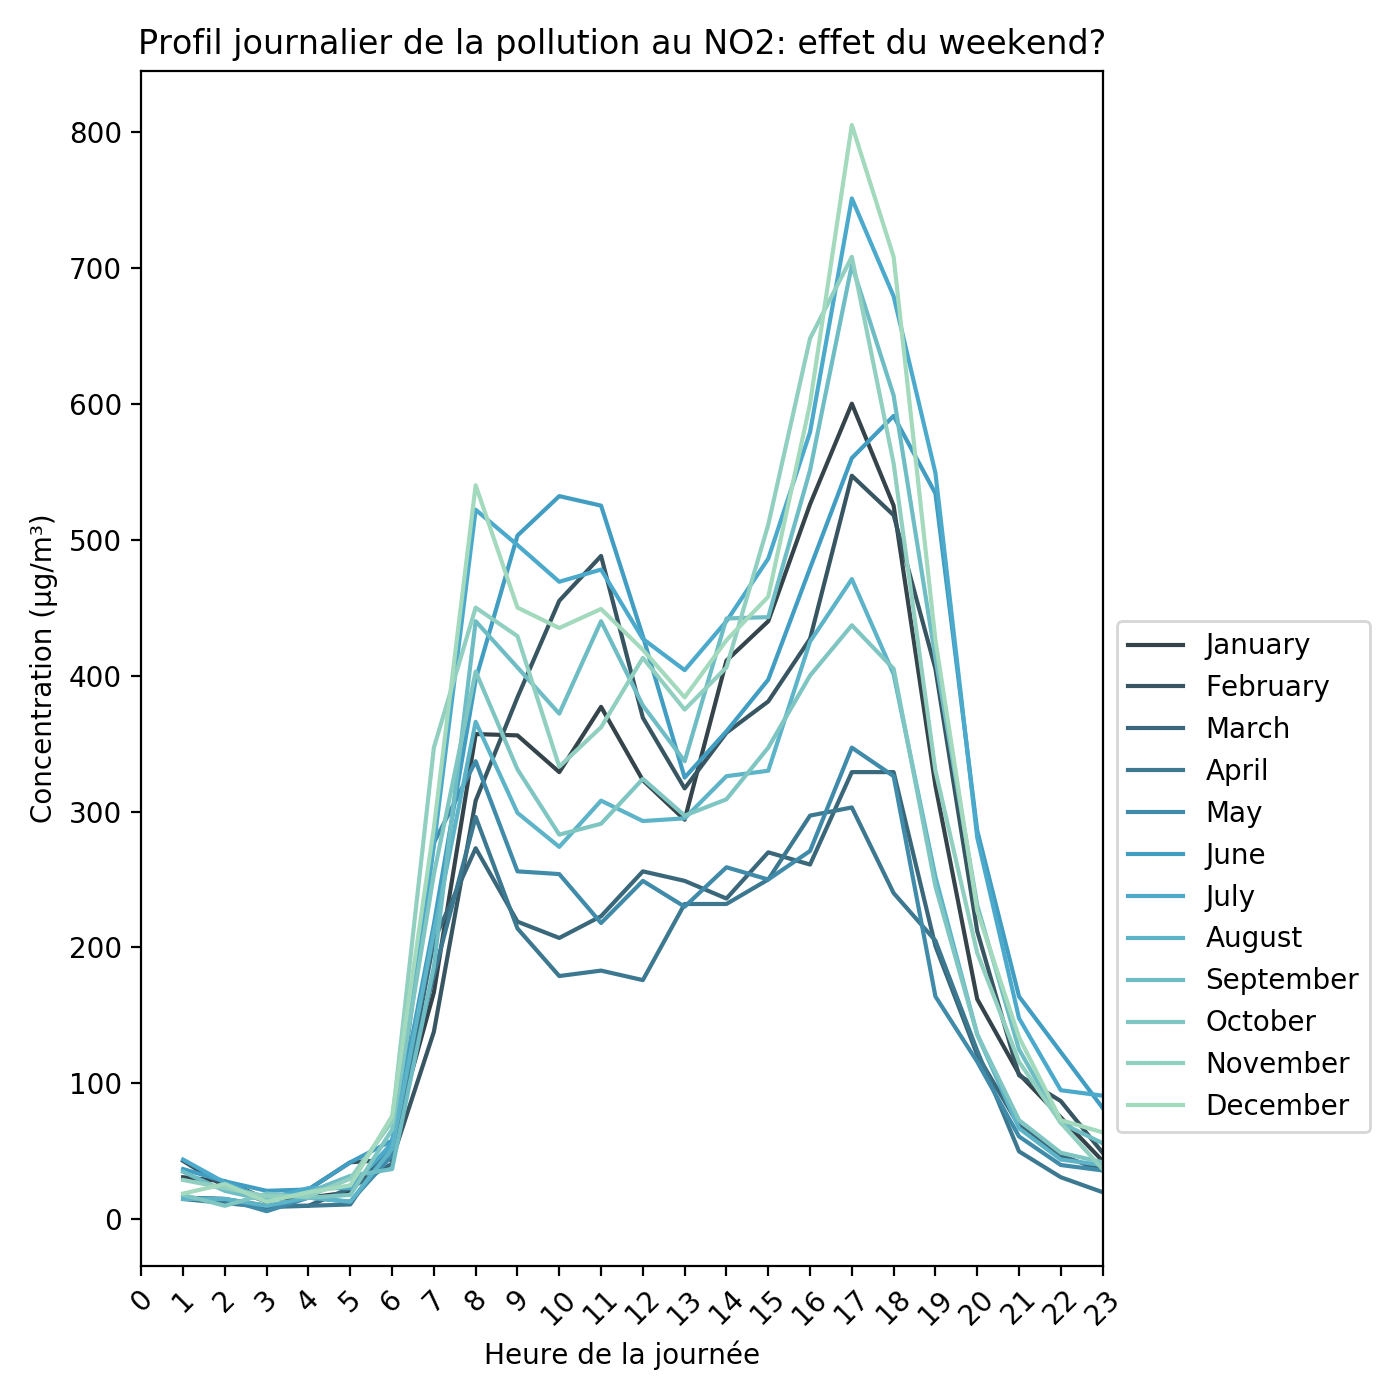

In [101]:

import calendar
df_bikes['month'] = df_bikes.index.month  # Janvier=0, .... Decembre=11
df_bikes['month'] = df_bikes['month'].apply(lambda x: calendar.month_abbr[x])
df_bikes.head()

sns.set_palette("GnBu_d", n_colors=12)
# sns.set_palette("colorblind", n_colors=12)

df_bikes_month = df_bikes.groupby(['month', df_bikes.index.hour])[
    'age'].count().unstack(level=0)

fig, axes = plt.subplots(1, 1, figsize=(7, 7), sharex=True)

df_bikes_month.plot(ax=axes)
axes.set_ylabel("Concentration (µg/m³)")
axes.set_xlabel("Heure de la journée")
axes.set_title(
    "Profil journalier de la pollution au NO2: effet du weekend?")
axes.set_xticks(np.arange(0, 24))
axes.set_xticklabels(np.arange(0, 24), rotation=45)
# axes.set_ylim(0, 90)
axes.legend(labels=calendar.month_name[1:], loc='lower left', bbox_to_anchor=(1, 0.1))

plt.tight_layout()

### <font color='red'> EXERCISE : Accidents by departement  </font>
Peform an analysis to check when the accidents are occuring by departement.

In [102]:
import pygal  # First import pygal

# Departement population: https://public.opendatasoft.com/explore/dataset/population-francaise-par-departement-2018/table/?disjunctive.departement&location=7,47.12995,3.41125&basemap=jawg.streets
path_target = "./dpt_population.csv"
url = "https://public.opendatasoft.com/explore/dataset/population-francaise-par-departement-2018/download/?format=csv&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
download(url, path_target, replace=False)

# Departement area: https://www.regions-et-departements.fr/departements-francais#departements_fichiers
path_target = "./dpt_area.csv"
url = "https://www.regions-et-departements.fr/fichiers/departements-francais.csv"
download(url, path_target, replace=False)

df_dtp_pop = pd.read_csv("dpt_population.csv", sep=";", low_memory=False)
df_dtp_area = pd.read_csv("dpt_area.csv", sep="\t", low_memory=False, skiprows=[102, 103, 104])
df_dtp_area['NUMÉRO']


df_dtp_area.set_index('NUMÉRO', inplace=True)

df_dtp_pop.set_index('Code Département', inplace=True)
df_dtp_pop.sort_index(inplace=True)


fr_chart = pygal.maps.fr.Departments(human_readable=True)

# display = "ration_tue"
display = "ratio_accident"


if display is "ratio_accident":
    fr_chart.title = 'Accidents by departement'
    gd = df_bikes.groupby(['departement']).size()
    gd = (gd / df_dtp_pop['Population'])  # mean accident per habitant
else:
    fr_chart.title = 'Deaths by departement'
    df_deads = df_bikes[df_bikes['gravite accident']=='3 - Tué']
    df_gravite = df_deads.groupby('departement').size()
    # gd = df_bikes.groupby(['departement']).aggregate(lambda: x->sum(x))
    gd = (df_gravite / df_dtp_pop['Population'])  # mean deaths per habitant

# Area normalization
normalization = True
if normalization is True:
    gd = (gd / df_dtp_area['SUPERFICIE (km²)'])
gd.dropna(inplace=True)   # anoying NA due to 1 vs 01 in datasets
fr_chart.add('Accidents', gd.to_dict())
fr_chart.render_in_browser()
# fr_chart.render_to_file('./chatr.svg')  # Write the chart in the specified file


file_sizes: 1.76MB [00:00, 2.64MB/s]                                            


Successfully downloaded file to ./dpt_population.csv


file_sizes: 100%|███████████████████████████| 5.77k/5.77k [00:00<00:00, 865kB/s]


Successfully downloaded file to ./dpt_area.csv


file:///tmp/tmpwcktlabb.html
